# Illustration of the Problem
![](MountainCar.png)

In [88]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
from collections import deque
import random

#Test out environment and grab state/action space parameters
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n
shape_obs = env.observation_space.shape
env.close()
#Action must be 0 (left), 1 (nothing), or 2 (right)

#Define initial/default parameters
class iparams: #initial parameters
    def __init__(self):
        #default hyperparameters
        self.buffersize = int(1E6) #Max Number of data points stored in buffer
        self.batchsize = 128 #BatchSize
        self.recentbuffer = self.batchsize*4
        self.shape_obs = shape_obs
        self.n_actions = n_actions
        self.nH = [120,120,120]
        self.nA = n_actions
        self.nS = shape_obs[0]
        self.nC = 32 #Dimensionality of RND Network Code
        self.gamma = 0.99 #Time discount factor
        self.lr = 0.002 #Adam Optimizer Learning Rate
        self.RND_lr = 0.0002
        self.n_episodes = 200
        self.alpha = 1.0


params = iparams()

#My favorite print function - repeats commands, doesn't always work with PyTorch
def printo(string):
    print(string,eval(string))

#Plotting mountain car trajectory from observations
def plot_trajectory(lst_obs):
    obs_vec = np.array(lst_obs)
    plt.figure(figsize=(10,3))
    time_addition = np.array(range(np.shape(obs_vec)[0]))/500
    default = np.array(range(1000))/1000*1.8-1.2
    plt.plot(obs_vec[:,0],np.sin(3*obs_vec[:,0])+time_addition,'.',
        label='Cart Trajectory')
    plt.plot(default,np.sin(3*default),label='Ground')
    plt.xlim([-1.2,0.6])
    plt.ylim([-1,1.1])
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical with Time Addition')
    plt.legend()
    plt.show()

#Data buffer for storing data
class bufferobject:
    def __init__(self,params):
        self.buffersize=params.buffersize
        self.defaultbatch = params.batchsize
        self.recentbuffer = params.recentbuffer
        self.index = 0
        #obs_dims = (self.buffersize,) + shape_obs
        #self.state = np.zeros(size=obs_dims)
        #self.actions = np
        #self.state = deque(maxlen=self.buffersize)
        #self.action = deque(maxlen=self.buffersize)
        #self.reward = deque(maxlen=self.buffersize)
        #self.nextstate = deque(maxlen=self.buffersize)
        self.experience = deque(maxlen=self.buffersize)
        self.recentexperience = deque(maxlen=self.recentbuffer)
    def add(self,s,a,r,s_,d):
        #self.state.append(s)
        #self.action.append(a)
        #self.reward.append(r)
        #self.nextstate.append(s_)
        #self.index +=1
        self.experience.append([s,a,r,s_,d])
        self.recentexperience.append([s,a,r,s_,d])
        self.index +=1
    def sample(self,batch = 32):
        #vec = range(min(self.index,self.buffersize))
        #ind = np.random.choice(a=vec,b=batchsize)
        #self.experience.sample
        K = min(self.index,self.buffersize,batch)
        samples = random.sample(self.experience, K)
        s,a,r,s_,d = zip(*samples)
        s = torch.tensor( s, dtype=torch.float)
        a = torch.tensor( a, dtype=torch.long).view(K, -1)
        r = torch.tensor( r, dtype=torch.float).view(K, -1)
        s_ = torch.tensor( s_, dtype=torch.float)
        d = torch.tensor( d, dtype=torch.float)
        return s,a,r,s_,d
    
    def sample_recent(self,batch = 32):
        K = min(self.index,self.recentbuffer,batch)
        samples = random.sample(self.recentexperience, K)
        
        s,a,r,s_,d = zip(*samples)
        s = torch.tensor( s, dtype=torch.float)
        a = torch.tensor( a, dtype=torch.long).view(K, -1)
        r = torch.tensor( r, dtype=torch.float).view(K, -1)
        s_ = torch.tensor( s_, dtype=torch.float)
        d = torch.tensor( d, dtype=torch.float)
        return s,a,r,s_,d


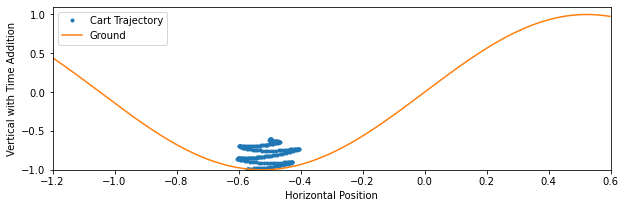

In [89]:
#Test Episode for Environment/Buffer
env = gym.make('MountainCar-v0')
s = env.reset()
buffer = bufferobject(params)
#printo('env.action_space')
#printo('env.observation_space')
#Action must be 0 (left), 1 (nothing), or 2 (right)
#observation, reward, done, _  = env.step(2) 
#printo('observation, reward, done')

lst_obs = []
d=False
while d==False:

    a = np.random.choice([0,1,2]) #NumPy Array
    s_, r, d, _ = env.step(a)
    buffer.add(s,a,r,s_,d)
    lst_obs.append(s)
    s =  s_
    _,actions,_,_,_ = buffer.sample(batch=5)
    #printo('actions')
plot_trajectory(lst_obs)
stest = s
env.close()

In [90]:
#Define Q network
class Qnet(torch.nn.Module):
    def __init__(self,params):
        super(Qnet, self).__init__()
        self.nS = params.nS
        self.nH = params.nH
        self.nA = params.nA
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(self.nS,self.nH[0]))
        for ind in range(len(self.nH)-1):
            self.layers.append(nn.Linear(self.nH[ind],self.nH[ind+1]))
        self.layers.append(nn.Linear(self.nH[-1],self.nA))

        self.optim = torch.optim.Adam(self.parameters(),lr=params.lr)

    def forward(self,x):
        #x should be a tensor of size (batch,nS)
        for ind in range(len(self.nH)-1):
            x = nn.functional.relu(self.layers[ind](x))
        x = self.layers[-1](x)
        return x


#Define Random Network Distillation (RND) network
class RNDnet(torch.nn.Module):
    def __init__(self,params):
        super(RNDnet, self).__init__()
        self.nS = params.nS
        self.nH = params.nH
        self.nA = params.nC
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(self.nS,self.nH[0]))
        for ind in range(len(self.nH)-1):
            self.layers.append(nn.Linear(self.nH[ind],self.nH[ind+1]))
        self.layers.append(nn.Linear(self.nH[-1],self.nA))

        self.optim = torch.optim.Adam(self.parameters(),lr=params.RND_lr)

    def forward(self,x):
        #x should be a tensor of size (batch,nS)
        for ind in range(len(self.nH)-1):
            x = nn.functional.relu(self.layers[ind](x))
        x = self.layers[-1](x)
        return x

# Separated Q function inputs and selection from the action sampling 
def Qs_(state,Qnet):
    with torch.no_grad():
        Qs = Qnet(state)
    return Qs

def Qs_mix(state,Qnet1,Qnet2,alpha=0.9):
    with torch.no_grad():
        Qs1 = Qnet1(state)
        Qs2 = Qnet2(state)
        Qmix = Qs1*alpha + Qs2*(1-alpha)
    return Qmix

# I don't love the proportional implementation since the proportional involves tuned constants to make the softmax work, 
# but it choose_action does select an action with sampling functionality
def choose_action(Qs,mode='epsgreedy', epsilon=0.1):
    #Qs should be the vector of state values
    #state should be a tensor of size (1,nS)
    sample = np.random.uniform()
    if mode.casefold() == 'epsgreedy'.casefold():
        if sample > epsilon:
            action = torch.argmax(Qs)
        else:
            action = np.random.choice(np.array(range(max(Qs.size()))))
            action = torch.tensor(action)
    if mode.casefold() == 'proportional'.casefold():
            Qs_norm = Qs*5/(torch.max(Qs)-torch.min(Qs))
            probs = torch.nn.Softmax(dim=0)(Qs_norm)
            dist = torch.distributions.categorical.Categorical(probs=probs)
            action = dist.sample()
    if mode.casefold() == 'optimal'.casefold():
        action = torch.argmax(Qs)
    #returns a tensor of size (1)
    return action

def updateRND(RNDnetwork_target,RNDnetwork,params,batch):
    s,a,r,s_,d = batch
    with torch.no_grad():
        RND_target = RNDnetwork_target(s)
    RND_pred = RNDnetwork(s)
    loss = torch.mean(torch.sum((RND_target-RND_pred)**2,dim=1))

    RNDnetwork.optim.zero_grad()
    loss.backward()
    RNDnetwork.optim.step()

    return RNDnetwork, loss

def RND_reward(s,RND_target,RND):
    if len(s.size()) == 1:
        s = s.unsqueeze(0)
    with torch.no_grad():
        vec1 = RND_target(s)
        #print(vec1)
        vec2 = RND(s)
        #print(vec2)
        distance = torch.sqrt(torch.sum((vec1-vec2)**2,dim=1))
    return distance

def updateQ(Qnetwork,params,batch,rewardtype='standard'):
    #state should be a tensor of size (batchsize,nS)
    s,a,r,s_,d = batch
    Qpreds = Qnetwork(s)
    #action number to onehot encoding
    a_mask = torch.nn.functional.one_hot(a,num_classes=params.nA).squeeze(dim=1)

    Qpred =torch.sum(Qpreds*a_mask,dim=1,keepdim=True)[0]
    #print('s',s.size(),s)
    #print('a',a.size(),a)
    #print('Qpreds',Qpreds.size(),Qpreds)
    #print('a_mask',a_mask.size(),a_mask)
    #print('Qpred',Qpred.size(),Qpred)
    Qpred = Qpred.squeeze()
    #print('Qpred',Qpred.size(),Qpred)
    Qmax = torch.max(Qnetwork(s_),dim=1,keepdim=True)[0]
    #print(Qmax)
    Qtarget = (r + params.gamma*Qmax)
    #print('Qtarget',Qtarget.size(),Qtarget)
    Qtarget = Qtarget.squeeze()
    #print('Qtarget',Qtarget.size(),Qtarget)
    loss = torch.mean((Qpred-Qtarget)**2)
    #print('loss',loss.size(),loss)
    Qnetwork.optim.zero_grad()
    loss.backward()
    Qnetwork.optim.step()

    return Qnetwork, loss

def plt_Qvalue(Q1,Q2,buffer):
    batch = buffer.sample(batch=params.batchsize*20)
    s,_,_,_,_ = batch
    #print('s[:,0]',s[:,0].size())
    with torch.no_grad():
        Q1s = Q1(s).detach()
        Q2s = Q2(s).detach()
        #Q1max,_ = torch.max(Q1s,dim=1)
        #Q1min,_ = torch.min(Q1s,dim=1)
        #Q2max,_ = torch.max(Q2s,dim=1)
        #Q2min,_ = torch.min(Q2s,dim=1)
        Q1_0 = Q1s[:,0]
        Q1_1 = Q1s[:,1]
        Q1_2 = Q1s[:,2]
        Q2_0 = Q2s[:,0]
        Q2_1 = Q2s[:,1]
        Q2_2 = Q2s[:,2]
    #print('Qmax1',Qmax.size())
    
    plt.figure()
    #plt.plot(s[:,0],Q1max,label='maxQ1')
    #plt.plot(s[:,0],Q1min,label='minQ1')
    #plt.plot(s[:,0],Q2max,label='maxQ2')
    #plt.plot(s[:,0],Q2min,label='minQ2')
    plt.plot(s[:,0],Q1_0,label='Q1 Action 0')
    plt.plot(s[:,0],Q1_1,label='Q1 Action 1')
    plt.plot(s[:,0],Q1_2,label='Q1 Action 2')
    plt.plot(s[:,0],Q2_0,label='Q2 Action 0')
    plt.plot(s[:,0],Q2_1,label='Q2 Action 1')
    plt.plot(s[:,0],Q2_2,label='Q2 Action 2')
    plt.legend()
    default = np.array(range(1000))/1000*1.8-1.2
    #plt.plot(obs_vec[:,0],np.sin(3*obs_vec[:,0])+time_addition,'.',
    #    label='Cart Trajectory')
    plt.plot(default,np.sin(3*default),label='Ground')
    plt.show()

In [91]:
#Testing the networks

#s2 = np.stack((s,s_,s_),axis=0)
Q1 = Qnet(params)
#x = Q.forward(s)
#x = Q.forward(s2)

#Make sure action selection works
Q2 = Qnet(params)
state = torch.tensor(stest).unsqueeze(dim=0)
#printo('state'); printo('state.size()')
for _ in range(10):
    #Qs = Qs_(state,Q1)
    Qs = Qs_mix(state,Q1,Q2,alpha=0.9)
    action = choose_action(Qs,epsilon=0.2,mode='epsgreedy')
    printo('action')    

#Grab samples from buffer
s,a,r,s_,d = buffer.sample(batch=1)
#Modify Reward
#Recompile
batch_ = s,a,r,s_,d
Q1, loss = updateQ(Q1,params,batch_)

#Grab samples from buffer
s,a,r,s_,d = buffer.sample_recent(batch=1)
#batch = buffer.sample(batch=4)

RND_target = RNDnet(params)
RND = RNDnet(params)

for iter in range(10):
    #Grab samples from buffer
    s,a,r,s_,d = buffer.sample_recent(batch=10)
    with torch.no_grad():
        vec1 = RND_target(s)
        #print(vec1)
        vec2 = RND(s)
        #print(vec2)
        distance = torch.sqrt(torch.sum((vec1-vec2)**2,dim=1))
        #print(distance)
    batch = buffer.sample_recent()
    RND, loss = updateRND(RND_target,RND,params,batch)
    print('iter = ',iter,' loss = ', loss,' distance = ',torch.mean(distance))




action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
action tensor(0)
iter =  0  loss =  tensor(0.7852, grad_fn=<MeanBackward0>)  distance =  tensor(0.8868)
iter =  1  loss =  tensor(0.7523, grad_fn=<MeanBackward0>)  distance =  tensor(0.8659)
iter =  2  loss =  tensor(0.7102, grad_fn=<MeanBackward0>)  distance =  tensor(0.8457)
iter =  3  loss =  tensor(0.6710, grad_fn=<MeanBackward0>)  distance =  tensor(0.8215)
iter =  4  loss =  tensor(0.6414, grad_fn=<MeanBackward0>)  distance =  tensor(0.7998)
iter =  5  loss =  tensor(0.6058, grad_fn=<MeanBackward0>)  distance =  tensor(0.7737)
iter =  6  loss =  tensor(0.5738, grad_fn=<MeanBackward0>)  distance =  tensor(0.7586)
iter =  7  loss =  tensor(0.5466, grad_fn=<MeanBackward0>)  distance =  tensor(0.7385)
iter =  8  loss =  tensor(0.5206, grad_fn=<MeanBackward0>)  distance =  tensor(0.7222)
iter =  9  loss =  tensor(0.4885, grad_fn=<Mean

In [92]:
#Initialize Networks and Buffers
Q1 = Qnet(params)
Q2 = Qnet(params)
RND_target = RNDnet(params)
RND = RNDnet(params)
env = gym.make('MountainCar-v0')
s = env.reset()
buffer = bufferobject(params)
#Loop through episodes
eps = 0
reward_list = []

Episode:    1, Reward: -200.0, Expl. Reward: 153.2, LossQ1: 0.8741, LossQ2: 0.5941, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:    2, Reward: -200.0, Expl. Reward: 151.9, LossQ1: 0.9971, LossQ2: 0.5770, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:    3, Reward: -200.0, Expl. Reward: 152.0, LossQ1: 1.0317, LossQ2: 0.5814, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:    4, Reward: -200.0, Expl. Reward: 152.6, LossQ1: 0.9601, LossQ2: 0.5833, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:    5, Reward: -200.0, Expl. Reward: 147.6, LossQ1: 1.0377, LossQ2: 0.5389, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:    6, Reward: -200.0, Expl. Reward: 148.7, LossQ1: 1.0014, LossQ2: 0.5434, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:    7, Reward: -200.0, Expl. Reward: 147.7, LossQ1: 0.5341, LossQ2: 1.4161, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:    8, Reward: -200.0, Expl. Reward: 149.1, LossQ1: 0.9781, LossQ2: 0.5431, MinPos: -1.0, MaxPos: -0.4, Alpha: 1.0
Episode:    9, R

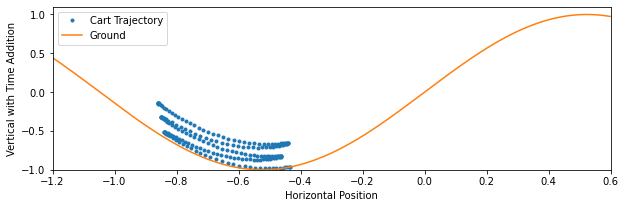

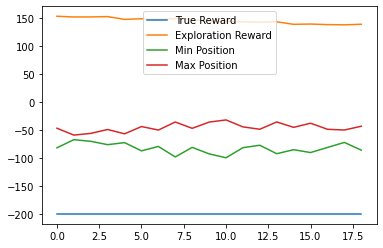

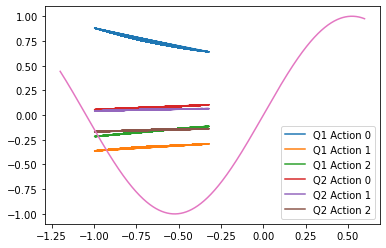

Episode:   20, Reward: -200.0, Expl. Reward: 133.0, LossQ1: 0.9046, LossQ2: 0.4339, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   21, Reward: -200.0, Expl. Reward: 134.5, LossQ1: 0.9166, LossQ2: 0.4311, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   22, Reward: -200.0, Expl. Reward: 134.6, LossQ1: 0.9962, LossQ2: 0.4448, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   23, Reward: -200.0, Expl. Reward: 134.2, LossQ1: 1.1988, LossQ2: 0.4678, MinPos: -0.9, MaxPos: -0.5, Alpha: 1.0
Episode:   24, Reward: -200.0, Expl. Reward: 133.7, LossQ1: 0.9305, LossQ2: 0.4381, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:   25, Reward: -200.0, Expl. Reward: 128.9, LossQ1: 0.9984, LossQ2: 0.4164, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   26, Reward: -200.0, Expl. Reward: 129.3, LossQ1: 1.0820, LossQ2: 0.4234, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:   27, Reward: -200.0, Expl. Reward: 129.5, LossQ1: 0.0255, LossQ2: 0.5409, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:   28, R

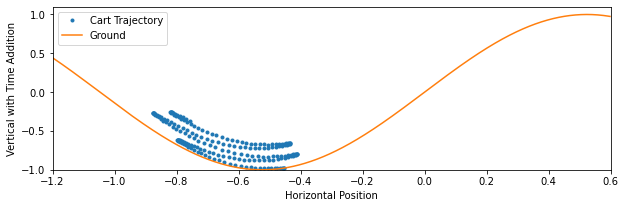

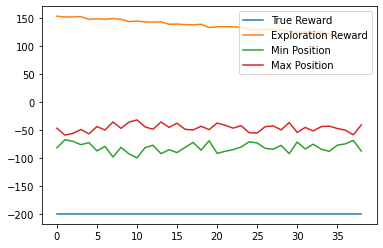

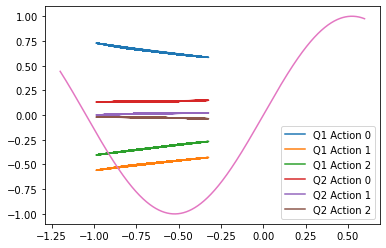

Episode:   40, Reward: -200.0, Expl. Reward: 117.2, LossQ1: 1.0136, LossQ2: 0.3420, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   41, Reward: -200.0, Expl. Reward: 116.7, LossQ1: 1.0379, LossQ2: 0.3411, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   42, Reward: -200.0, Expl. Reward: 116.5, LossQ1: 0.9598, LossQ2: 0.3333, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   43, Reward: -200.0, Expl. Reward: 116.5, LossQ1: 0.9623, LossQ2: 0.3341, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   44, Reward: -200.0, Expl. Reward: 117.4, LossQ1: 0.9974, LossQ2: 0.3416, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   45, Reward: -200.0, Expl. Reward: 112.9, LossQ1: 0.0040, LossQ2: 0.4242, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   46, Reward: -200.0, Expl. Reward: 112.6, LossQ1: 1.0166, LossQ2: 0.3375, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   47, Reward: -200.0, Expl. Reward: 112.6, LossQ1: 1.0022, LossQ2: 0.3161, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   48, R

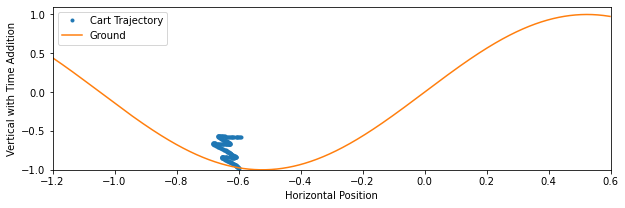

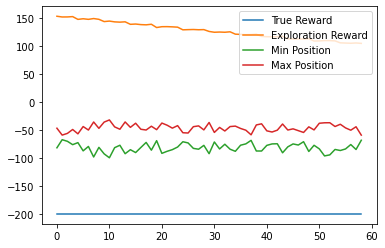

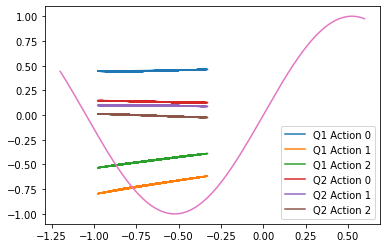

Episode:   60, Reward: -200.0, Expl. Reward: 101.1, LossQ1: 1.0002, LossQ2: 0.2521, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:   61, Reward: -200.0, Expl. Reward: 101.1, LossQ1: 0.9863, LossQ2: 0.2484, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   62, Reward: -200.0, Expl. Reward: 101.2, LossQ1: 0.0369, LossQ2: 0.3347, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   63, Reward: -200.0, Expl. Reward: 101.5, LossQ1: 0.9821, LossQ2: 0.2513, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   64, Reward: -200.0, Expl. Reward: 101.8, LossQ1: 0.9995, LossQ2: 0.2560, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   65, Reward: -200.0, Expl. Reward: 97.7, LossQ1: 0.8684, LossQ2: 0.2235, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   66, Reward: -200.0, Expl. Reward: 98.3, LossQ1: 0.8436, LossQ2: 0.2248, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   67, Reward: -200.0, Expl. Reward: 99.0, LossQ1: 1.0274, LossQ2: 0.2417, MinPos: -1.0, MaxPos: -0.4, Alpha: 1.0
Episode:   68, Rewa

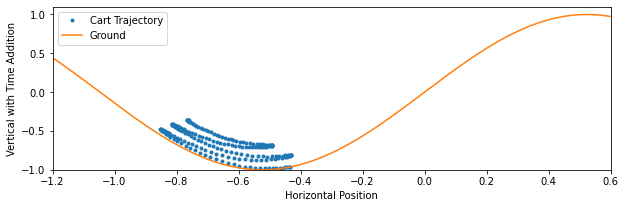

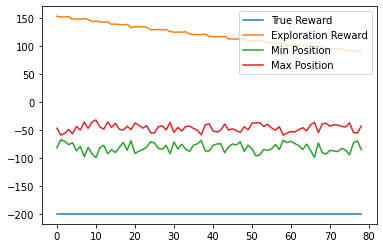

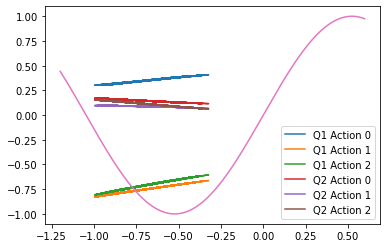

Episode:   80, Reward: -200.0, Expl. Reward: 87.8, LossQ1: 1.0165, LossQ2: 0.1953, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   81, Reward: -200.0, Expl. Reward: 87.5, LossQ1: 1.0003, LossQ2: 0.1903, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   82, Reward: -200.0, Expl. Reward: 87.8, LossQ1: 1.0345, LossQ2: 0.2013, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:   83, Reward: -200.0, Expl. Reward: 87.5, LossQ1: 1.0089, LossQ2: 0.1929, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   84, Reward: -200.0, Expl. Reward: 87.5, LossQ1: 0.9941, LossQ2: 0.1884, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:   85, Reward: -200.0, Expl. Reward: 85.9, LossQ1: 1.0213, LossQ2: 0.1838, MinPos: -1.0, MaxPos: -0.3, Alpha: 1.0
Episode:   86, Reward: -200.0, Expl. Reward: 85.8, LossQ1: 1.0107, LossQ2: 0.1814, MinPos: -1.0, MaxPos: -0.3, Alpha: 1.0
Episode:   87, Reward: -200.0, Expl. Reward: 85.0, LossQ1: 1.0432, LossQ2: 0.1901, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:   88, Reward: -

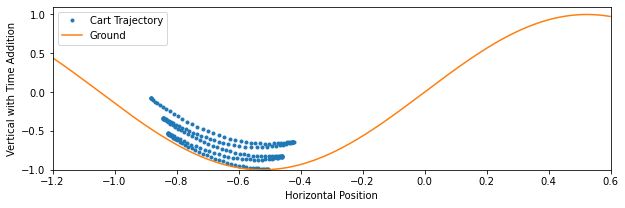

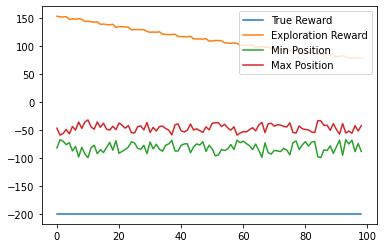

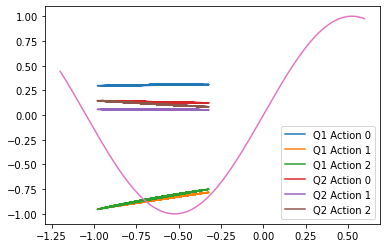

Episode:  100, Reward: -200.0, Expl. Reward: 75.4, LossQ1: 0.0205, LossQ2: 0.2046, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  101, Reward: -200.0, Expl. Reward: 76.1, LossQ1: 0.9881, LossQ2: 0.1368, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  102, Reward: -200.0, Expl. Reward: 75.4, LossQ1: 0.9739, LossQ2: 0.1317, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  103, Reward: -200.0, Expl. Reward: 75.3, LossQ1: 0.9923, LossQ2: 0.1408, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  104, Reward: -200.0, Expl. Reward: 76.1, LossQ1: 0.9789, LossQ2: 0.1395, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  105, Reward: -200.0, Expl. Reward: 73.0, LossQ1: 1.0140, LossQ2: 0.1345, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  106, Reward: -200.0, Expl. Reward: 73.1, LossQ1: 1.0034, LossQ2: 0.1335, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  107, Reward: -200.0, Expl. Reward: 72.5, LossQ1: 1.0049, LossQ2: 0.1327, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  108, Reward: -

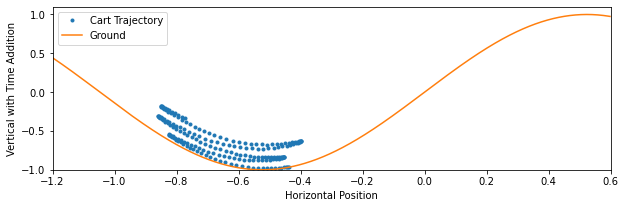

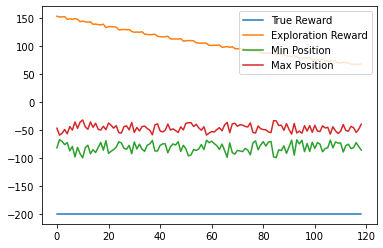

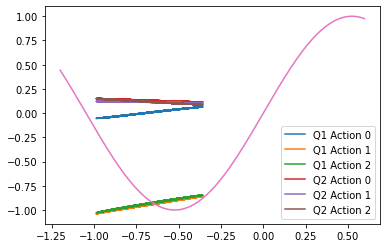

Episode:  120, Reward: -200.0, Expl. Reward: 64.7, LossQ1: 0.9354, LossQ2: 0.0986, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  121, Reward: -200.0, Expl. Reward: 64.6, LossQ1: 0.9479, LossQ2: 0.0995, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  122, Reward: -200.0, Expl. Reward: 64.8, LossQ1: 0.9961, LossQ2: 0.1044, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  123, Reward: -200.0, Expl. Reward: 64.8, LossQ1: 0.9809, LossQ2: 0.1036, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  124, Reward: -200.0, Expl. Reward: 64.6, LossQ1: 0.0529, LossQ2: 0.1069, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  125, Reward: -200.0, Expl. Reward: 62.2, LossQ1: 1.0108, LossQ2: 0.1031, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  126, Reward: -200.0, Expl. Reward: 62.1, LossQ1: 0.0046, LossQ2: 0.1136, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  127, Reward: -200.0, Expl. Reward: 62.4, LossQ1: 1.1024, LossQ2: 0.1084, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  128, Reward: -

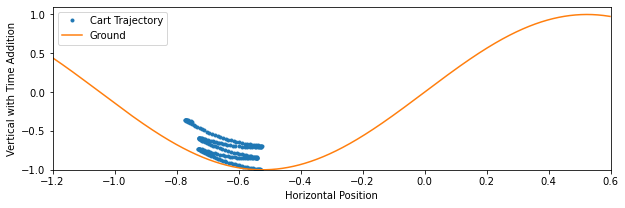

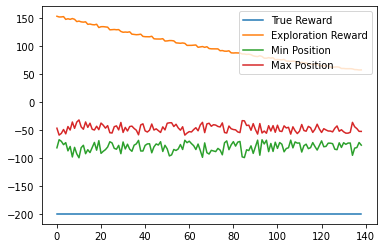

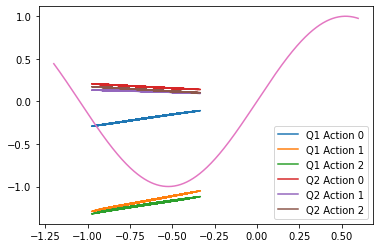

Episode:  140, Reward: -200.0, Expl. Reward: 55.2, LossQ1: 1.0757, LossQ2: 0.0842, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  141, Reward: -200.0, Expl. Reward: 55.4, LossQ1: 0.0285, LossQ2: 0.1028, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  142, Reward: -200.0, Expl. Reward: 55.1, LossQ1: 1.0715, LossQ2: 0.0836, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  143, Reward: -200.0, Expl. Reward: 56.6, LossQ1: 1.0490, LossQ2: 0.0811, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  144, Reward: -200.0, Expl. Reward: 55.5, LossQ1: 0.9875, LossQ2: 0.0783, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  145, Reward: -200.0, Expl. Reward: 54.0, LossQ1: 1.0571, LossQ2: 0.0777, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  146, Reward: -200.0, Expl. Reward: 52.8, LossQ1: 0.9324, LossQ2: 0.0651, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  147, Reward: -200.0, Expl. Reward: 53.2, LossQ1: 0.0038, LossQ2: 0.0773, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  148, Reward: -

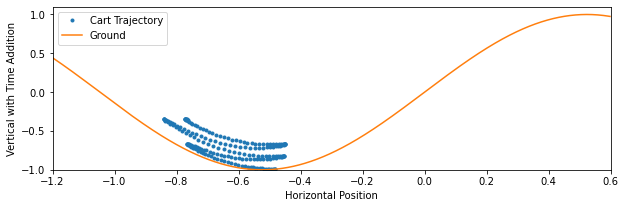

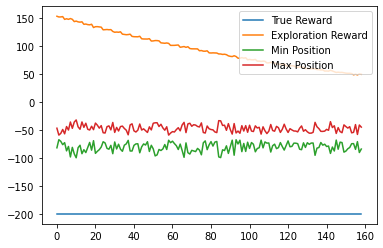

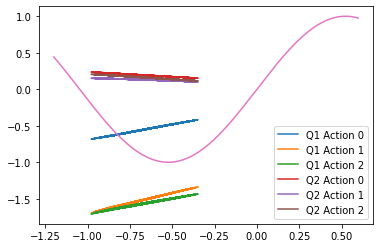

Episode:  160, Reward: -200.0, Expl. Reward: 46.8, LossQ1: 0.9524, LossQ2: 0.0521, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  161, Reward: -200.0, Expl. Reward: 47.1, LossQ1: 0.9928, LossQ2: 0.0549, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  162, Reward: -200.0, Expl. Reward: 46.5, LossQ1: 1.0641, LossQ2: 0.0621, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  163, Reward: -200.0, Expl. Reward: 47.1, LossQ1: 1.1332, LossQ2: 0.0653, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  164, Reward: -200.0, Expl. Reward: 48.4, LossQ1: 1.0081, LossQ2: 0.0558, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  165, Reward: -200.0, Expl. Reward: 45.1, LossQ1: 0.0083, LossQ2: 0.0592, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  166, Reward: -200.0, Expl. Reward: 45.6, LossQ1: 0.9742, LossQ2: 0.0500, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  167, Reward: -200.0, Expl. Reward: 45.3, LossQ1: 1.0905, LossQ2: 0.0580, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  168, Reward: -

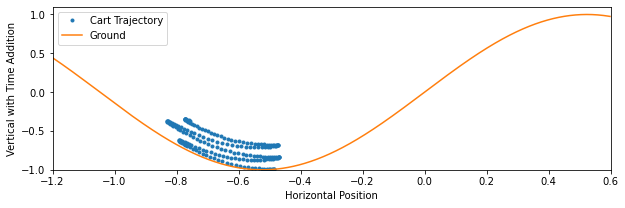

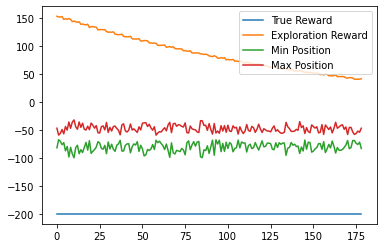

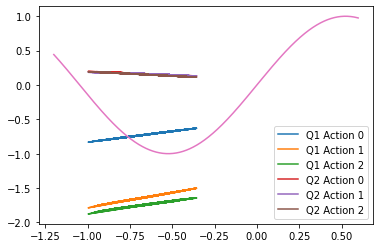

Episode:  180, Reward: -200.0, Expl. Reward: 39.4, LossQ1: 0.0100, LossQ2: 0.0421, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  181, Reward: -200.0, Expl. Reward: 38.8, LossQ1: 0.9374, LossQ2: 0.0369, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  182, Reward: -200.0, Expl. Reward: 39.4, LossQ1: 1.0419, LossQ2: 0.0433, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  183, Reward: -200.0, Expl. Reward: 39.2, LossQ1: 0.9684, LossQ2: 0.0379, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  184, Reward: -200.0, Expl. Reward: 39.1, LossQ1: 1.0720, LossQ2: 0.0442, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  185, Reward: -200.0, Expl. Reward: 37.5, LossQ1: 0.9735, LossQ2: 0.0346, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  186, Reward: -200.0, Expl. Reward: 39.0, LossQ1: 1.0209, LossQ2: 0.0368, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode:  187, Reward: -200.0, Expl. Reward: 36.9, LossQ1: 0.9712, LossQ2: 0.0345, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  188, Reward: -

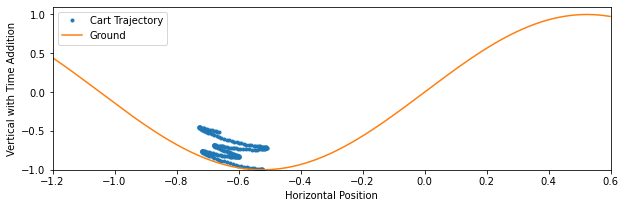

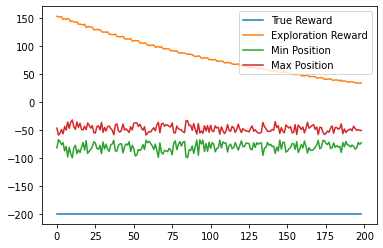

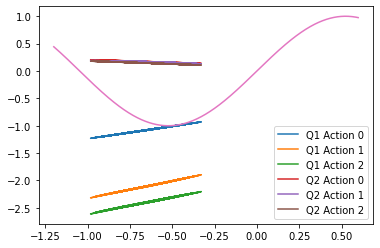

Episode:  200, Reward: -200.0, Expl. Reward: 31.6, LossQ1: 0.9903, LossQ2: 0.0260, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  201, Reward: -200.0, Expl. Reward: 32.8, LossQ1: 1.0460, LossQ2: 0.0289, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  202, Reward: -200.0, Expl. Reward: 31.8, LossQ1: 0.9077, LossQ2: 0.0236, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode:  203, Reward: -200.0, Expl. Reward: 33.0, LossQ1: 1.0104, LossQ2: 0.0273, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  204, Reward: -200.0, Expl. Reward: 31.9, LossQ1: 0.9467, LossQ2: 0.0255, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  205, Reward: -200.0, Expl. Reward: 30.2, LossQ1: 1.1764, LossQ2: 0.0305, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode:  206, Reward: -200.0, Expl. Reward: 31.4, LossQ1: 0.9479, LossQ2: 0.0227, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode:  207, Reward: -200.0, Expl. Reward: 30.3, LossQ1: 1.0460, LossQ2: 0.0259, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode:  208, Reward: -

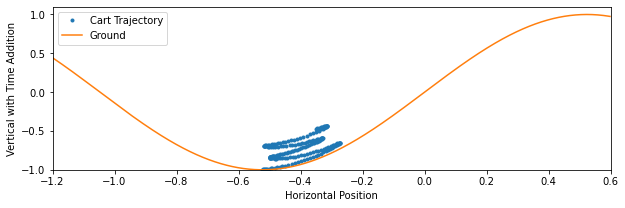

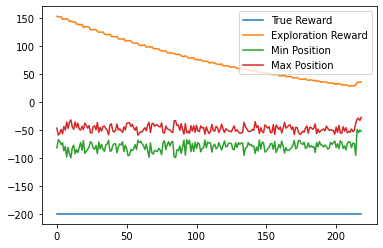

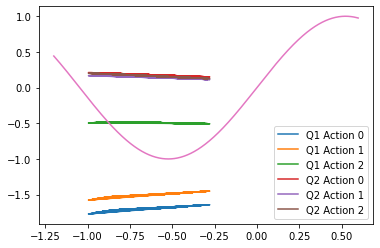

Episode:  220, Reward: -200.0, Expl. Reward: 35.3, LossQ1: 0.0040, LossQ2: 0.0157, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  221, Reward: -200.0, Expl. Reward: 35.3, LossQ1: 0.0350, LossQ2: 0.0149, MinPos: -0.7, MaxPos: -0.2, Alpha: 1.0
Episode:  222, Reward: -200.0, Expl. Reward: 34.9, LossQ1: 0.0919, LossQ2: 0.0136, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  223, Reward: -200.0, Expl. Reward: 33.8, LossQ1: 0.0896, LossQ2: 0.0135, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  224, Reward: -200.0, Expl. Reward: 33.7, LossQ1: 0.0490, LossQ2: 0.0155, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  225, Reward: -200.0, Expl. Reward: 31.7, LossQ1: 0.0098, LossQ2: 0.0147, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  226, Reward: -200.0, Expl. Reward: 33.0, LossQ1: 0.0007, LossQ2: 0.0176, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  227, Reward: -200.0, Expl. Reward: 32.1, LossQ1: 0.0264, LossQ2: 0.0119, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  228, Reward: -

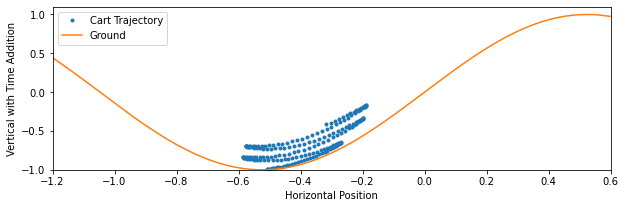

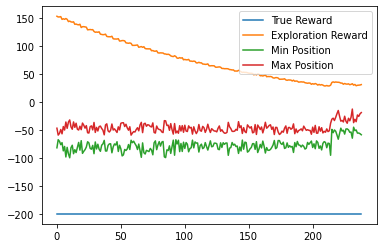

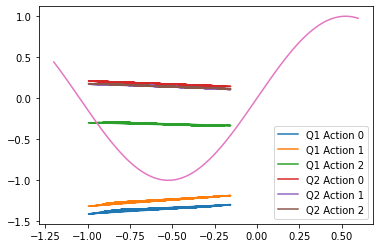

Episode:  240, Reward: -200.0, Expl. Reward: 29.0, LossQ1: 0.0050, LossQ2: 0.0084, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  241, Reward: -200.0, Expl. Reward: 26.9, LossQ1: 0.0014, LossQ2: 0.0109, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  242, Reward: -200.0, Expl. Reward: 28.7, LossQ1: 0.0002, LossQ2: 0.0160, MinPos: -0.5, MaxPos: -0.2, Alpha: 1.0
Episode:  243, Reward: -200.0, Expl. Reward: 27.3, LossQ1: 0.0002, LossQ2: 0.0124, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  244, Reward: -200.0, Expl. Reward: 29.1, LossQ1: 0.0011, LossQ2: 0.0224, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  245, Reward: -200.0, Expl. Reward: 26.9, LossQ1: 0.0006, LossQ2: 0.0081, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  246, Reward: -200.0, Expl. Reward: 25.7, LossQ1: 0.0019, LossQ2: 0.0140, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  247, Reward: -200.0, Expl. Reward: 26.2, LossQ1: 0.9349, LossQ2: 0.0281, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  248, Reward: -

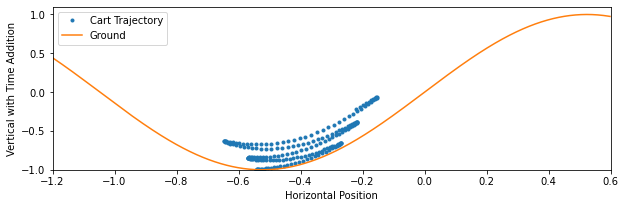

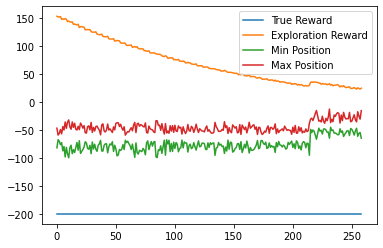

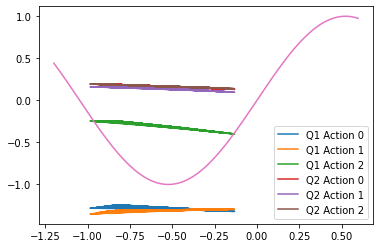

Episode:  260, Reward: -200.0, Expl. Reward: 20.9, LossQ1: 0.0011, LossQ2: 0.0108, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  261, Reward: -200.0, Expl. Reward: 22.5, LossQ1: 0.0012, LossQ2: 0.0103, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  262, Reward: -200.0, Expl. Reward: 20.8, LossQ1: 0.0012, LossQ2: 0.0096, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  263, Reward: -200.0, Expl. Reward: 22.4, LossQ1: 0.8630, LossQ2: 0.0148, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  264, Reward: -200.0, Expl. Reward: 21.0, LossQ1: 0.0024, LossQ2: 0.0114, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  265, Reward: -200.0, Expl. Reward: 20.0, LossQ1: 0.0024, LossQ2: 0.0111, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  266, Reward: -200.0, Expl. Reward: 21.1, LossQ1: 0.0037, LossQ2: 0.0121, MinPos: -0.5, MaxPos: -0.2, Alpha: 1.0
Episode:  267, Reward: -200.0, Expl. Reward: 22.6, LossQ1: 0.0055, LossQ2: 0.0092, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  268, Reward: -

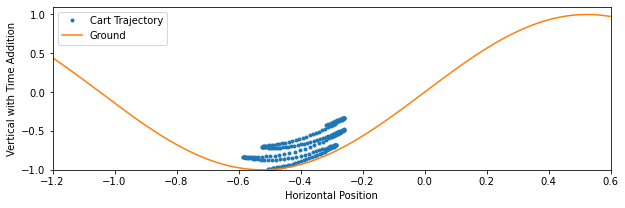

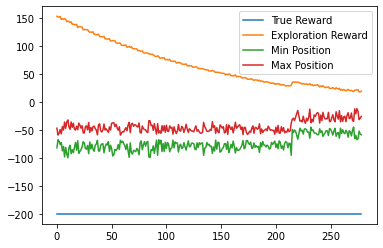

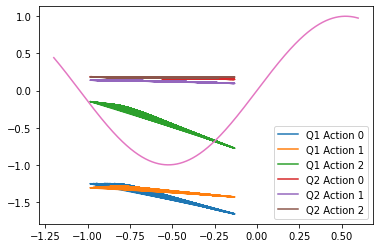

Episode:  280, Reward: -200.0, Expl. Reward: 17.1, LossQ1: 0.0186, LossQ2: 0.0106, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  281, Reward: -200.0, Expl. Reward: 16.5, LossQ1: 0.0165, LossQ2: 0.0115, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  282, Reward: -200.0, Expl. Reward: 16.0, LossQ1: 0.0177, LossQ2: 0.0106, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  283, Reward: -200.0, Expl. Reward: 16.5, LossQ1: 0.0443, LossQ2: 0.0089, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  284, Reward: -200.0, Expl. Reward: 16.6, LossQ1: 0.0286, LossQ2: 0.0119, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  285, Reward: -200.0, Expl. Reward: 15.8, LossQ1: 0.0257, LossQ2: 0.0110, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  286, Reward: -200.0, Expl. Reward: 16.0, LossQ1: 0.5980, LossQ2: 0.0136, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  287, Reward: -200.0, Expl. Reward: 15.6, LossQ1: 0.0252, LossQ2: 0.0255, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  288, Reward: -

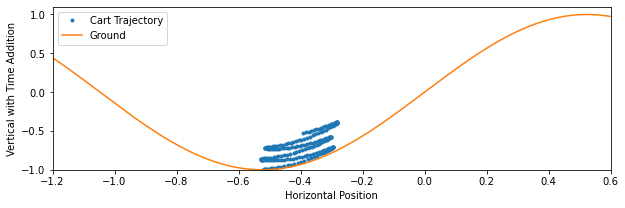

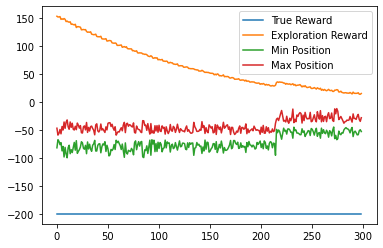

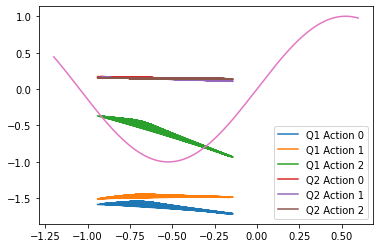

Episode:  300, Reward: -200.0, Expl. Reward: 13.5, LossQ1: 0.0160, LossQ2: 0.0092, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  301, Reward: -200.0, Expl. Reward: 14.5, LossQ1: 0.0144, LossQ2: 0.0126, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  302, Reward: -200.0, Expl. Reward: 14.0, LossQ1: 0.0135, LossQ2: 0.0119, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  303, Reward: -200.0, Expl. Reward: 14.0, LossQ1: 0.6525, LossQ2: 0.0156, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  304, Reward: -200.0, Expl. Reward: 13.4, LossQ1: 0.0131, LossQ2: 0.0119, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  305, Reward: -200.0, Expl. Reward: 12.8, LossQ1: 0.7268, LossQ2: 0.0169, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  306, Reward: -200.0, Expl. Reward: 12.1, LossQ1: 0.0114, LossQ2: 0.0111, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  307, Reward: -200.0, Expl. Reward: 12.2, LossQ1: 0.0159, LossQ2: 0.0104, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  308, Reward: -

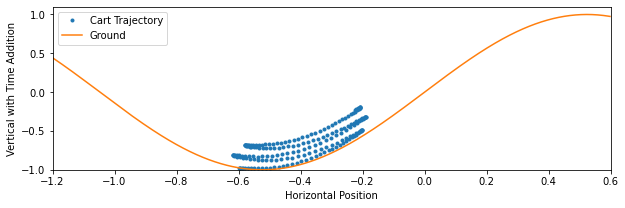

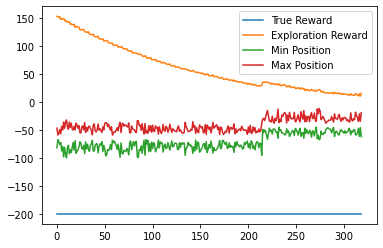

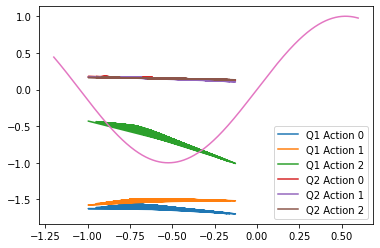

Episode:  320, Reward: -200.0, Expl. Reward: 10.1, LossQ1: 0.0179, LossQ2: 0.0096, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  321, Reward: -200.0, Expl. Reward: 10.1, LossQ1: 0.0178, LossQ2: 0.0148, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  322, Reward: -200.0, Expl. Reward: 12.8, LossQ1: 0.0153, LossQ2: 0.0098, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  323, Reward: -200.0, Expl. Reward: 12.5, LossQ1: 0.0114, LossQ2: 0.0086, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  324, Reward: -200.0, Expl. Reward: 14.6, LossQ1: 0.0152, LossQ2: 0.0119, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  325, Reward: -200.0, Expl. Reward:  9.9, LossQ1: 0.6746, LossQ2: 0.0119, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  326, Reward: -200.0, Expl. Reward:  9.0, LossQ1: 0.0221, LossQ2: 0.0088, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  327, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.0248, LossQ2: 0.0099, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  328, Reward: -

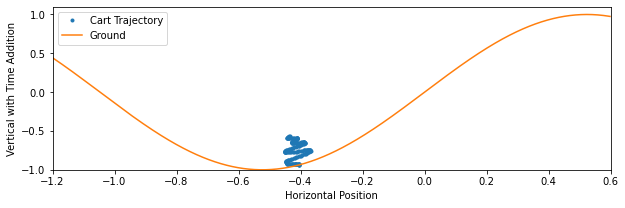

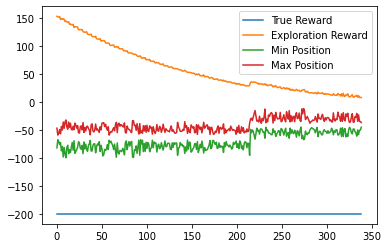

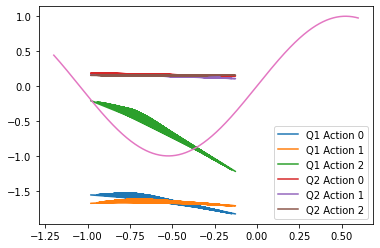

Episode:  340, Reward: -200.0, Expl. Reward: 11.5, LossQ1: 0.5933, LossQ2: 0.0129, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  341, Reward: -200.0, Expl. Reward: 10.4, LossQ1: 0.8125, LossQ2: 0.0124, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  342, Reward: -200.0, Expl. Reward:  7.2, LossQ1: 0.0840, LossQ2: 0.0113, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  343, Reward: -200.0, Expl. Reward:  9.8, LossQ1: 0.0496, LossQ2: 0.0141, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  344, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 1.3572, LossQ2: 0.0128, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  345, Reward: -200.0, Expl. Reward:  8.4, LossQ1: 1.7205, LossQ2: 0.0103, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  346, Reward: -200.0, Expl. Reward: 11.8, LossQ1: 0.9496, LossQ2: 0.0088, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  347, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 0.0619, LossQ2: 0.0149, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  348, Reward: -

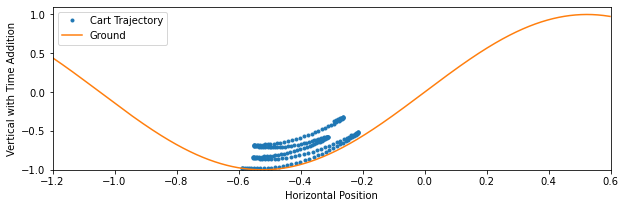

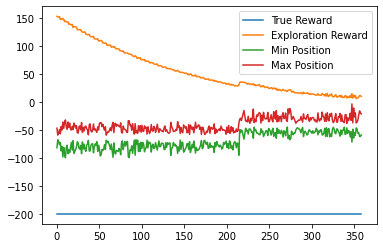

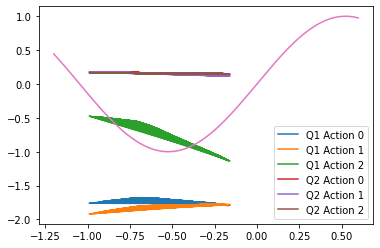

Episode:  360, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.0208, LossQ2: 0.0071, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  361, Reward: -200.0, Expl. Reward:  8.3, LossQ1: 0.0213, LossQ2: 0.0073, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  362, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.0223, LossQ2: 0.0107, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  363, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0200, LossQ2: 0.0085, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  364, Reward: -200.0, Expl. Reward:  9.3, LossQ1: 0.0193, LossQ2: 0.0084, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  365, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0224, LossQ2: 0.0067, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  366, Reward: -200.0, Expl. Reward:  7.5, LossQ1: 0.0220, LossQ2: 0.0104, MinPos: -0.5, MaxPos: -0.2, Alpha: 1.0
Episode:  367, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.0186, LossQ2: 0.0072, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  368, Reward: -

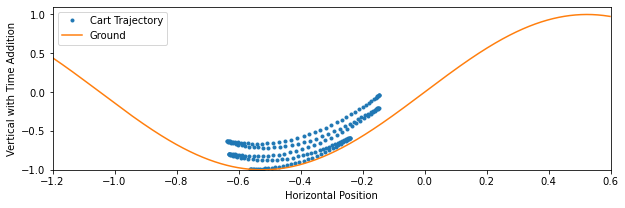

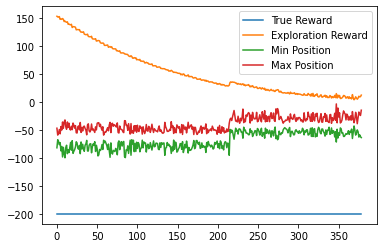

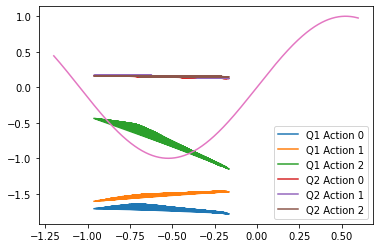

Episode:  380, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0280, LossQ2: 0.0113, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  381, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.6587, LossQ2: 0.0092, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  382, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 1.5766, LossQ2: 0.0107, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  383, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.0764, LossQ2: 0.0106, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  384, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0275, LossQ2: 0.0089, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  385, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 1.4518, LossQ2: 0.0094, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  386, Reward: -200.0, Expl. Reward: 12.0, LossQ1: 0.0217, LossQ2: 0.0077, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  387, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0325, LossQ2: 0.0081, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  388, Reward: -

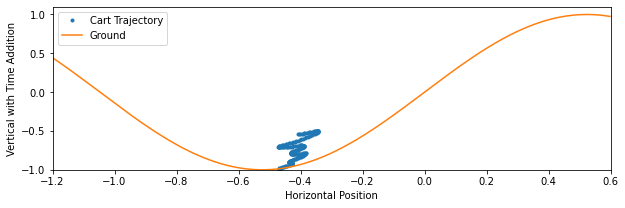

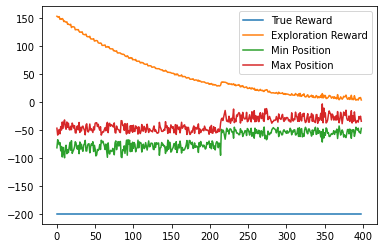

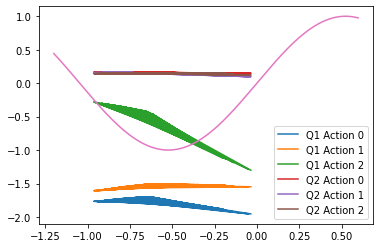

Episode:  400, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.0571, LossQ2: 0.0075, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  401, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0561, LossQ2: 0.0068, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  402, Reward: -200.0, Expl. Reward: 12.0, LossQ1: 0.0485, LossQ2: 0.0081, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode:  403, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0609, LossQ2: 0.0083, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  404, Reward: -200.0, Expl. Reward: 12.3, LossQ1: 0.9973, LossQ2: 0.0075, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode:  405, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.5940, LossQ2: 0.0063, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  406, Reward: -200.0, Expl. Reward:  7.3, LossQ1: 0.5411, LossQ2: 0.0062, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  407, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.9428, LossQ2: 0.0074, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  408, Reward: -

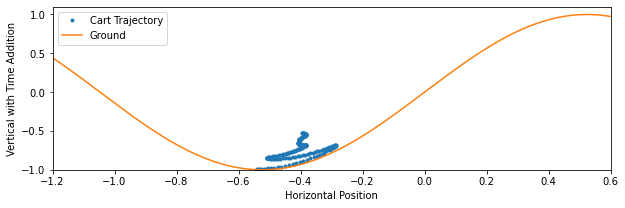

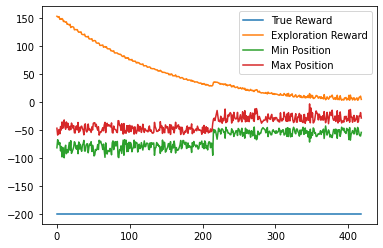

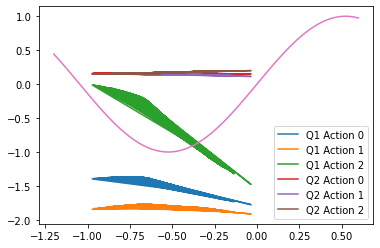

Episode:  420, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.1218, LossQ2: 0.0091, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  421, Reward: -200.0, Expl. Reward:  6.8, LossQ1: 0.6313, LossQ2: 0.0050, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  422, Reward: -200.0, Expl. Reward:  9.8, LossQ1: 0.6800, LossQ2: 0.0065, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  423, Reward: -200.0, Expl. Reward: 10.8, LossQ1: 0.7317, LossQ2: 0.0065, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  424, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0959, LossQ2: 0.0074, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  425, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.1147, LossQ2: 0.0081, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  426, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 1.2169, LossQ2: 0.0090, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  427, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 1.4447, LossQ2: 0.0087, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  428, Reward: -

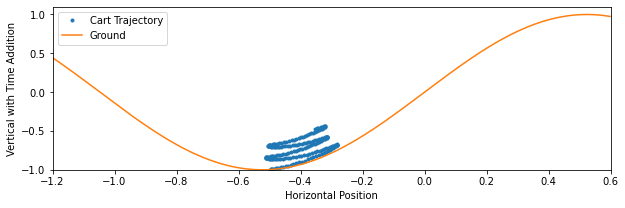

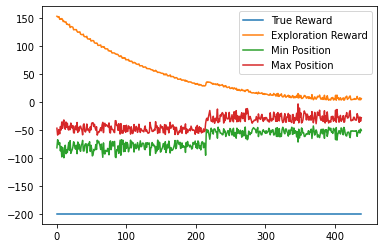

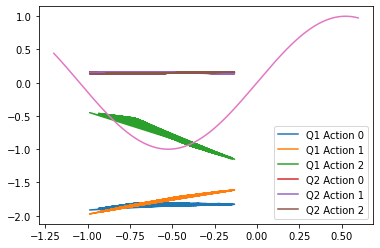

Episode:  440, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0310, LossQ2: 0.0066, MinPos: -0.4, MaxPos: -0.4, Alpha: 1.0
Episode:  441, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.0283, LossQ2: 0.0060, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  442, Reward: -200.0, Expl. Reward: 10.2, LossQ1: 0.0334, LossQ2: 0.0062, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  443, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0322, LossQ2: 0.0065, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  444, Reward: -200.0, Expl. Reward:  9.2, LossQ1: 0.0408, LossQ2: 0.0074, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  445, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.7561, LossQ2: 0.0045, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  446, Reward: -200.0, Expl. Reward:  9.1, LossQ1: 0.6515, LossQ2: 0.0067, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  447, Reward: -200.0, Expl. Reward:  6.5, LossQ1: 0.0885, LossQ2: 0.0107, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  448, Reward: -

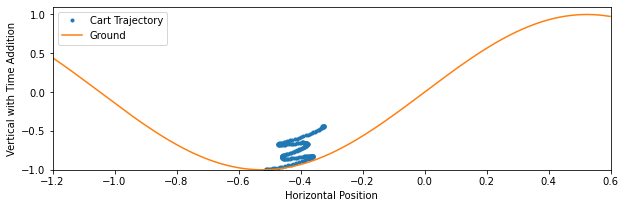

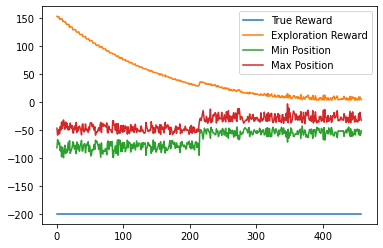

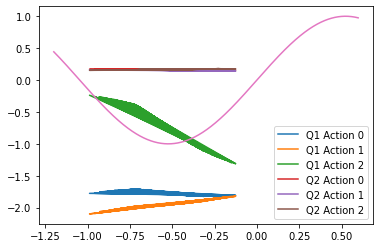

Episode:  460, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.0567, LossQ2: 0.0072, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  461, Reward: -200.0, Expl. Reward:  9.5, LossQ1: 0.4661, LossQ2: 0.0056, MinPos: -0.6, MaxPos: -0.1, Alpha: 1.0
Episode:  462, Reward: -200.0, Expl. Reward:  2.9, LossQ1: 0.0609, LossQ2: 0.0072, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  463, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 1.2765, LossQ2: 0.0067, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  464, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0513, LossQ2: 0.0051, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  465, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 1.1533, LossQ2: 0.0073, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  466, Reward: -200.0, Expl. Reward:  7.0, LossQ1: 0.0406, LossQ2: 0.0045, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  467, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.7074, LossQ2: 0.0069, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  468, Reward: -

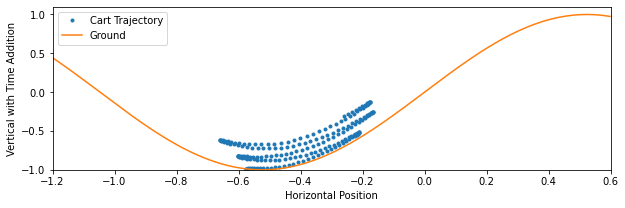

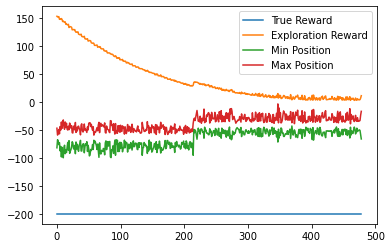

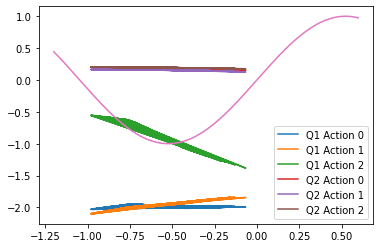

Episode:  480, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.0330, LossQ2: 0.0060, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  481, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.0303, LossQ2: 0.0099, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  482, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 1.1417, LossQ2: 0.0063, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  483, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0420, LossQ2: 0.0060, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  484, Reward: -200.0, Expl. Reward:  7.2, LossQ1: 0.0360, LossQ2: 0.0074, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  485, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.9120, LossQ2: 0.0057, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  486, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.0328, LossQ2: 0.0086, MinPos: -0.4, MaxPos: -0.4, Alpha: 1.0
Episode:  487, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0298, LossQ2: 0.0048, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  488, Reward: -

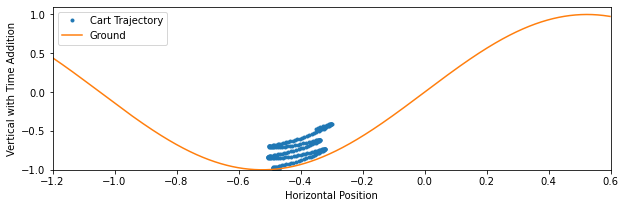

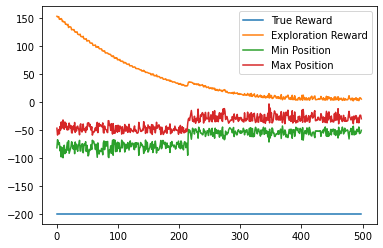

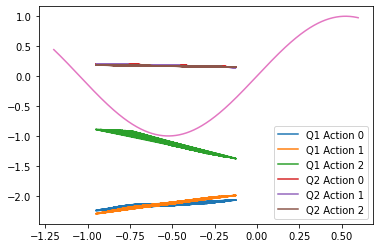

Episode:  500, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0167, LossQ2: 0.0049, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  501, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.9481, LossQ2: 0.0063, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  502, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.0151, LossQ2: 0.0061, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  503, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0145, LossQ2: 0.0049, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  504, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.7149, LossQ2: 0.0056, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  505, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0166, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  506, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0199, LossQ2: 0.0056, MinPos: -0.4, MaxPos: -0.4, Alpha: 1.0
Episode:  507, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 1.1445, LossQ2: 0.0044, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  508, Reward: -

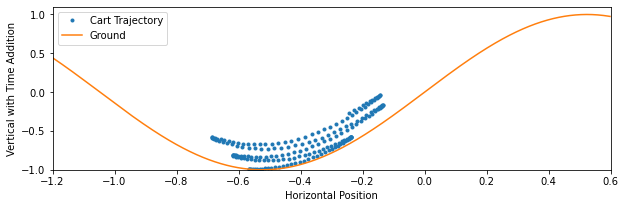

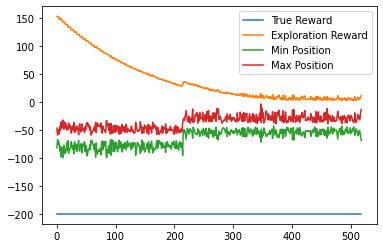

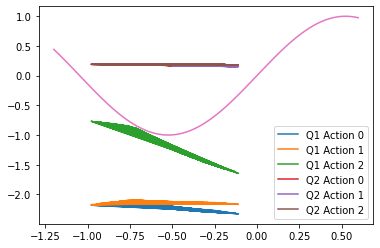

Episode:  520, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0395, LossQ2: 0.0063, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  521, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.0422, LossQ2: 0.0065, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  522, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.4647, LossQ2: 0.0064, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  523, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.9176, LossQ2: 0.0057, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  524, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0413, LossQ2: 0.0049, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  525, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0487, LossQ2: 0.0055, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  526, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.0520, LossQ2: 0.0065, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  527, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.8219, LossQ2: 0.0064, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  528, Reward: -

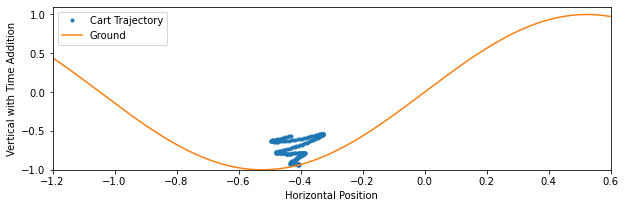

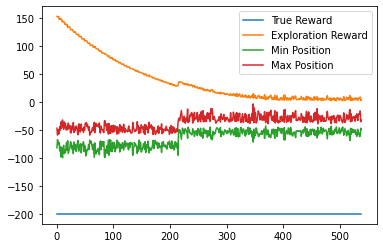

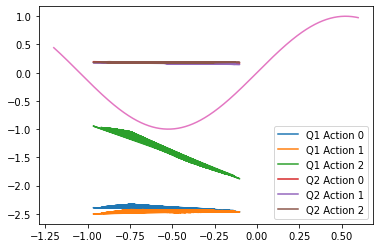

Episode:  540, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0383, LossQ2: 0.0039, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  541, Reward: -200.0, Expl. Reward:  8.0, LossQ1: 0.0491, LossQ2: 0.0075, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  542, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0389, LossQ2: 0.0046, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  543, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0353, LossQ2: 0.0055, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  544, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.0264, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  545, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.0279, LossQ2: 0.0037, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  546, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.7398, LossQ2: 0.0072, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  547, Reward: -200.0, Expl. Reward:  6.8, LossQ1: 0.7313, LossQ2: 0.0052, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  548, Reward: -

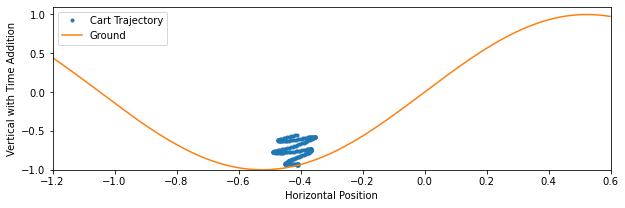

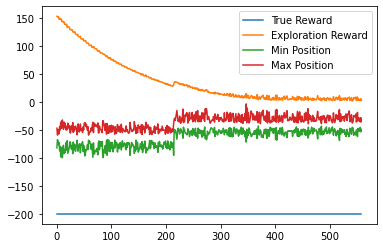

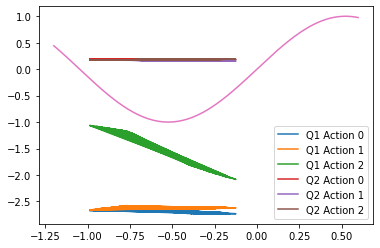

Episode:  560, Reward: -200.0, Expl. Reward:  7.2, LossQ1: 0.0522, LossQ2: 0.0075, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  561, Reward: -200.0, Expl. Reward: 10.5, LossQ1: 0.0555, LossQ2: 0.0065, MinPos: -0.6, MaxPos: -0.1, Alpha: 1.0
Episode:  562, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 1.2865, LossQ2: 0.0062, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  563, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0569, LossQ2: 0.0056, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  564, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.0503, LossQ2: 0.0052, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  565, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0599, LossQ2: 0.0050, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  566, Reward: -200.0, Expl. Reward:  9.7, LossQ1: 0.8892, LossQ2: 0.0047, MinPos: -0.6, MaxPos: -0.1, Alpha: 1.0
Episode:  567, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0571, LossQ2: 0.0057, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  568, Reward: -

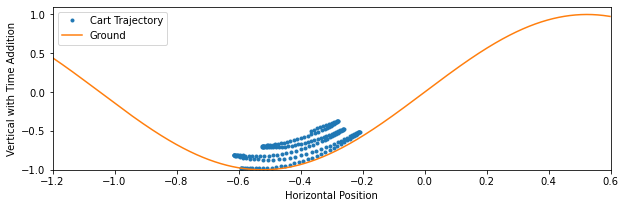

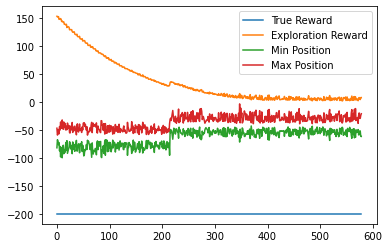

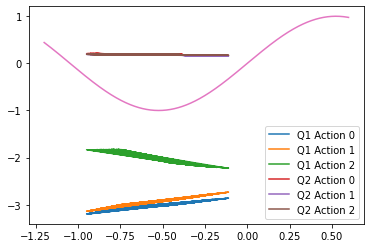

Episode:  580, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0135, LossQ2: 0.0056, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  581, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.8045, LossQ2: 0.0071, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  582, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 1.1927, LossQ2: 0.0050, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  583, Reward: -200.0, Expl. Reward:  7.5, LossQ1: 1.3879, LossQ2: 0.0042, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  584, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.8894, LossQ2: 0.0043, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  585, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.8226, LossQ2: 0.0054, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  586, Reward: -200.0, Expl. Reward: 11.2, LossQ1: 0.8509, LossQ2: 0.0038, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode:  587, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0585, LossQ2: 0.0062, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  588, Reward: -

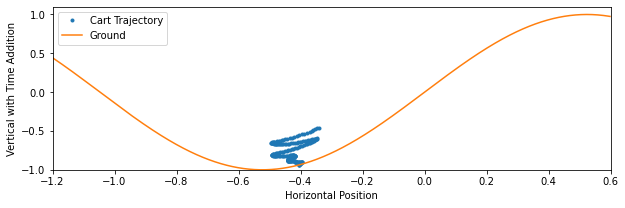

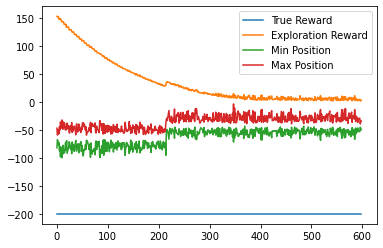

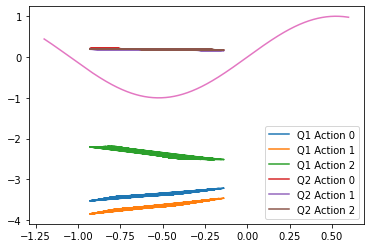

Episode:  600, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0073, LossQ2: 0.0038, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  601, Reward: -200.0, Expl. Reward: 10.2, LossQ1: 0.8755, LossQ2: 0.0043, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  602, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 0.0070, LossQ2: 0.0037, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  603, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.8213, LossQ2: 0.0041, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  604, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.8396, LossQ2: 0.0045, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  605, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0123, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  606, Reward: -200.0, Expl. Reward:  8.2, LossQ1: 0.0149, LossQ2: 0.0037, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  607, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.0149, LossQ2: 0.0033, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  608, Reward: -

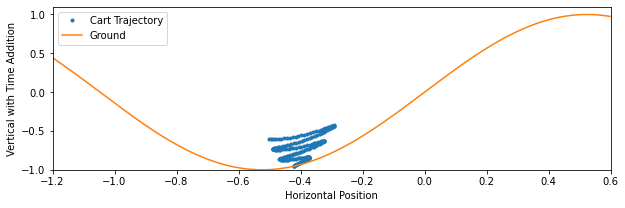

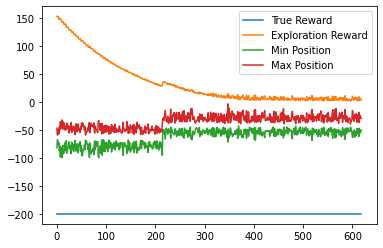

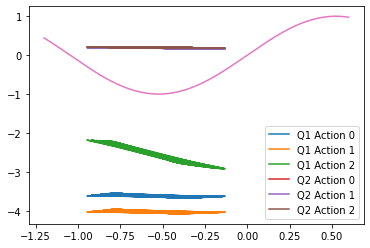

Episode:  620, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.0290, LossQ2: 0.0040, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  621, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7665, LossQ2: 0.0038, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  622, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.0378, LossQ2: 0.0046, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  623, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.7584, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  624, Reward: -200.0, Expl. Reward:  7.1, LossQ1: 0.0309, LossQ2: 0.0036, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  625, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0412, LossQ2: 0.0041, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  626, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.6888, LossQ2: 0.0044, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  627, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.8336, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  628, Reward: -

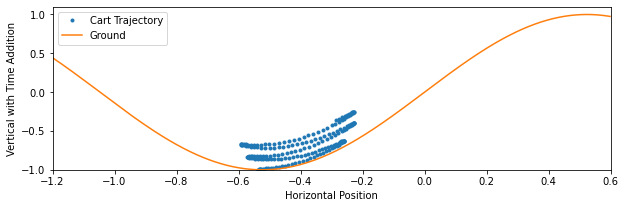

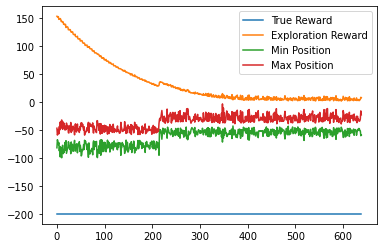

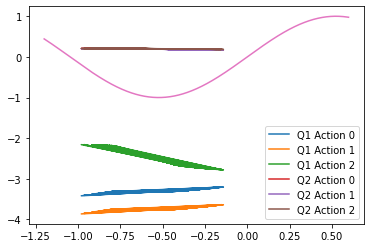

Episode:  640, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.7744, LossQ2: 0.0031, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  641, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 1.0672, LossQ2: 0.0031, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  642, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.8228, LossQ2: 0.0031, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  643, Reward: -200.0, Expl. Reward:  7.4, LossQ1: 0.6709, LossQ2: 0.0048, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  644, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.8085, LossQ2: 0.0042, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  645, Reward: -200.0, Expl. Reward: 10.1, LossQ1: 0.0445, LossQ2: 0.0041, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode:  646, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.7586, LossQ2: 0.0039, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  647, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0259, LossQ2: 0.0039, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  648, Reward: -

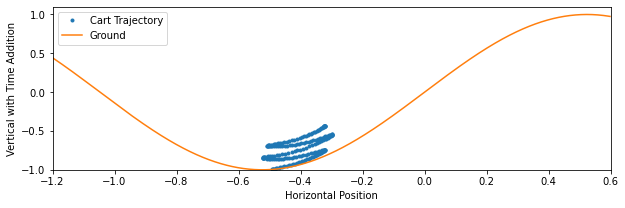

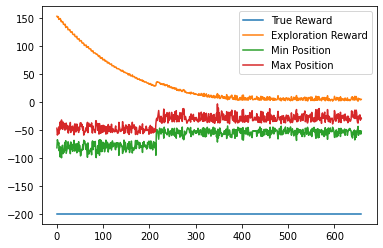

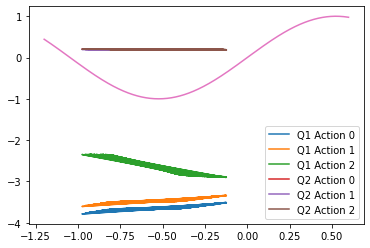

Episode:  660, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.7145, LossQ2: 0.0039, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  661, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.6691, LossQ2: 0.0046, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  662, Reward: -200.0, Expl. Reward:  9.2, LossQ1: 1.0063, LossQ2: 0.0035, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  663, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.7366, LossQ2: 0.0047, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  664, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.7000, LossQ2: 0.0035, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  665, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0241, LossQ2: 0.0031, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  666, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 1.8172, LossQ2: 0.0041, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  667, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0691, LossQ2: 0.0041, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  668, Reward: -

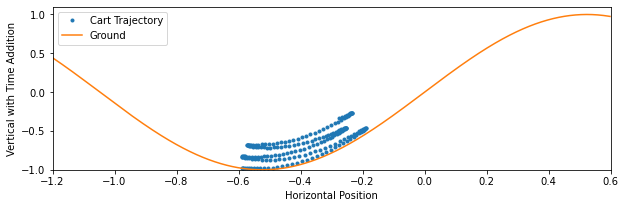

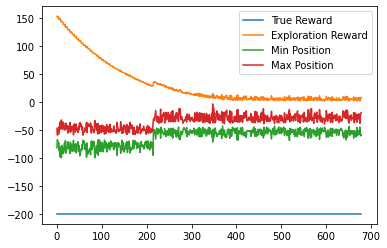

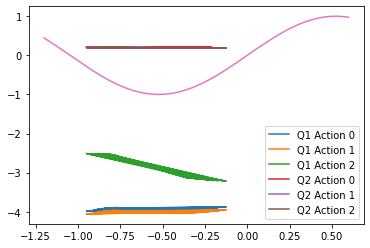

Episode:  680, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0367, LossQ2: 0.0048, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  681, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.6300, LossQ2: 0.0048, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  682, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.5915, LossQ2: 0.0044, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  683, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.0323, LossQ2: 0.0044, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  684, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.0281, LossQ2: 0.0036, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  685, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0236, LossQ2: 0.0035, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  686, Reward: -200.0, Expl. Reward:  3.9, LossQ1: 0.8427, LossQ2: 0.0031, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  687, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.7467, LossQ2: 0.0031, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  688, Reward: -

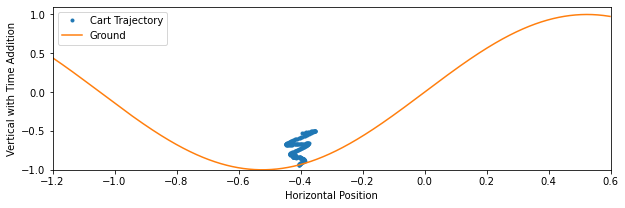

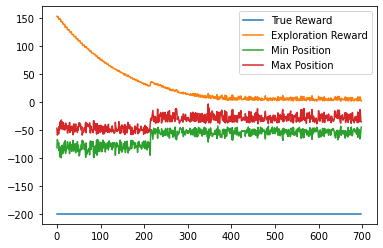

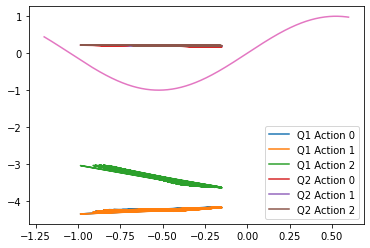

Episode:  700, Reward: -200.0, Expl. Reward:  2.9, LossQ1: 0.7625, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  701, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 1.1939, LossQ2: 0.0036, MinPos: -0.4, MaxPos: -0.3, Alpha: 1.0
Episode:  702, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0222, LossQ2: 0.0044, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  703, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7720, LossQ2: 0.0025, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  704, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.7724, LossQ2: 0.0036, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  705, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.9274, LossQ2: 0.0027, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  706, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 1.0586, LossQ2: 0.0019, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  707, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.0447, LossQ2: 0.0051, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  708, Reward: -

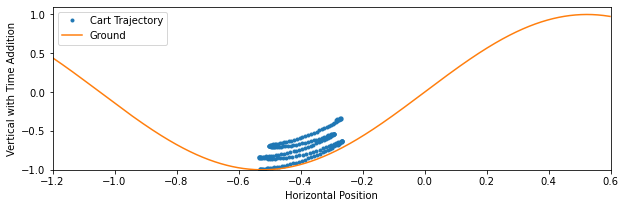

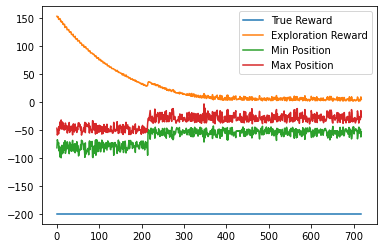

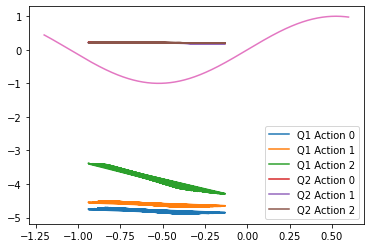

Episode:  720, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 1.1520, LossQ2: 0.0037, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  721, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.9491, LossQ2: 0.0031, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode:  722, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.7735, LossQ2: 0.0035, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode:  723, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.6461, LossQ2: 0.0035, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  724, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.7259, LossQ2: 0.0028, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  725, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.7885, LossQ2: 0.0037, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  726, Reward: -200.0, Expl. Reward:  7.1, LossQ1: 0.7852, LossQ2: 0.0039, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode:  727, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.8135, LossQ2: 0.0032, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode:  728, Reward: -

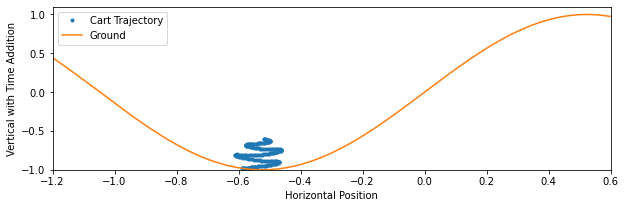

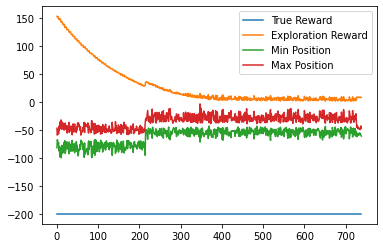

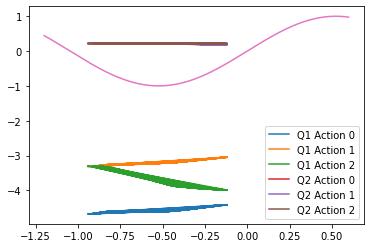

Episode:  740, Reward: -200.0, Expl. Reward:  8.3, LossQ1: 0.0489, LossQ2: 0.0029, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  741, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.2894, LossQ2: 0.0034, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  742, Reward: -200.0, Expl. Reward:  6.8, LossQ1: 0.0784, LossQ2: 0.0029, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  743, Reward: -200.0, Expl. Reward:  9.2, LossQ1: 0.0062, LossQ2: 0.0030, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  744, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 0.0515, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  745, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0764, LossQ2: 0.0024, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  746, Reward: -200.0, Expl. Reward:  7.3, LossQ1: 0.0013, LossQ2: 0.0039, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  747, Reward: -200.0, Expl. Reward:  9.0, LossQ1: 0.0447, LossQ2: 0.0034, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  748, Reward: -

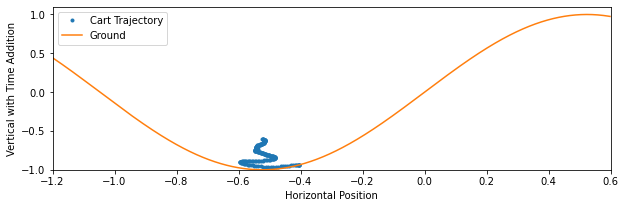

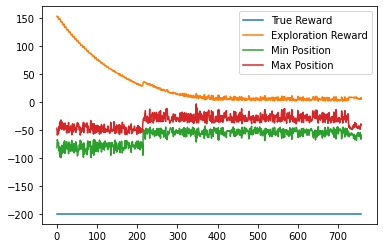

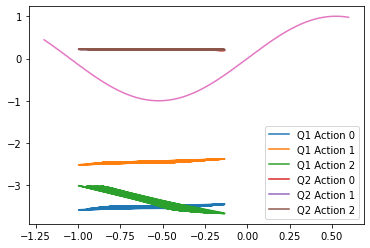

Episode:  760, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0242, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  761, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0027, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  762, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0002, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  763, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0012, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  764, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.0013, LossQ2: 0.0028, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  765, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0008, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  766, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.0050, LossQ2: 0.0029, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  767, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0002, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  768, Reward: -

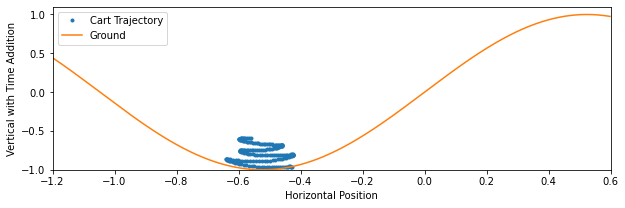

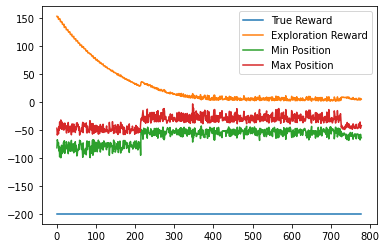

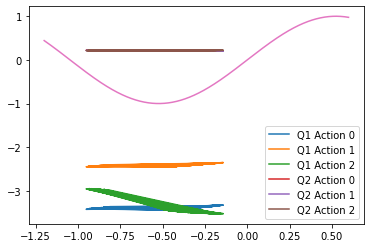

Episode:  780, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0093, LossQ2: 0.0031, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  781, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.0051, LossQ2: 0.0031, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  782, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.0003, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  783, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.0031, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  784, Reward: -200.0, Expl. Reward:  7.4, LossQ1: 0.0040, LossQ2: 0.0024, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  785, Reward: -200.0, Expl. Reward:  7.6, LossQ1: 0.0005, LossQ2: 0.0029, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  786, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0010, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  787, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0012, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  788, Reward: -

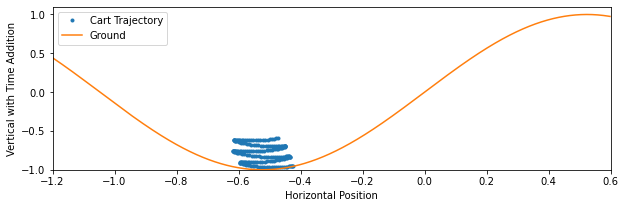

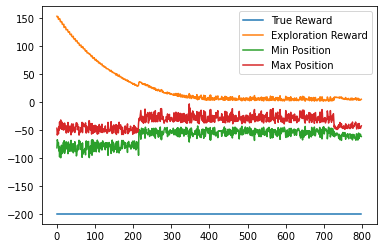

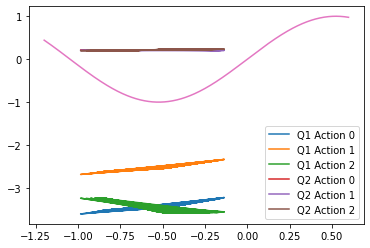

Episode:  800, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0141, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  801, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0105, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  802, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.0039, LossQ2: 0.0033, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  803, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.0027, LossQ2: 0.0026, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  804, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0049, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  805, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0039, LossQ2: 0.0029, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  806, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0102, LossQ2: 0.0030, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  807, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0038, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  808, Reward: -

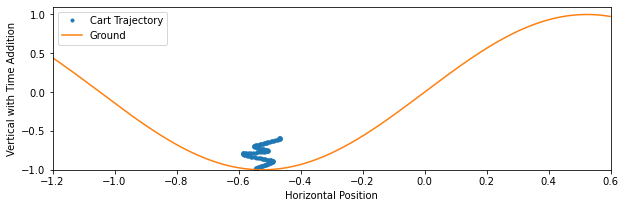

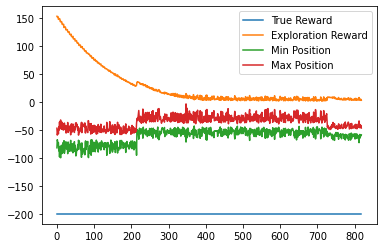

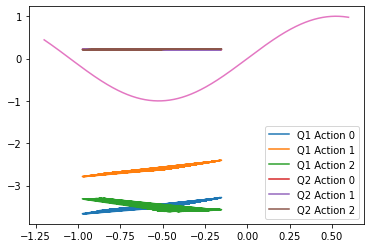

Episode:  820, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.0050, LossQ2: 0.0037, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  821, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.8655, LossQ2: 0.0030, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  822, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.0046, LossQ2: 0.0032, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  823, Reward: -200.0, Expl. Reward:  3.9, LossQ1: 0.0196, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  824, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.8248, LossQ2: 0.0030, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  825, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.8562, LossQ2: 0.0035, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  826, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0064, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  827, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.8470, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  828, Reward: -

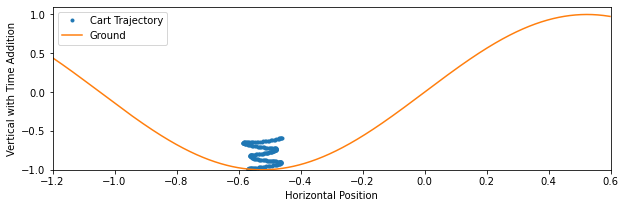

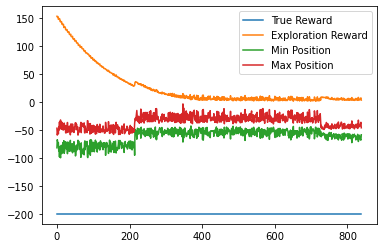

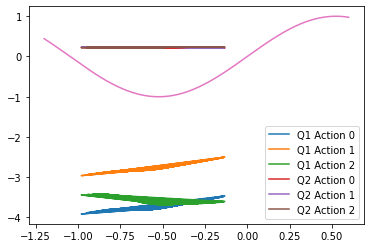

Episode:  840, Reward: -200.0, Expl. Reward:  5.5, LossQ1: 0.0084, LossQ2: 0.0032, MinPos: -0.7, MaxPos: -0.3, Alpha: 1.0
Episode:  841, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0086, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  842, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.7490, LossQ2: 0.0030, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  843, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.0050, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  844, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0081, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  845, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0085, LossQ2: 0.0025, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  846, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0073, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  847, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.0103, LossQ2: 0.0035, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  848, Reward: -

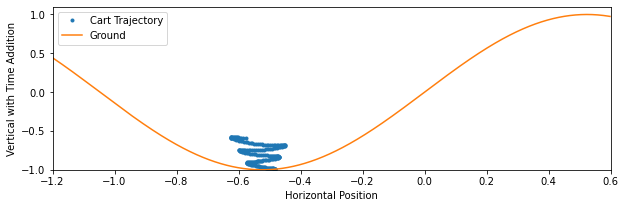

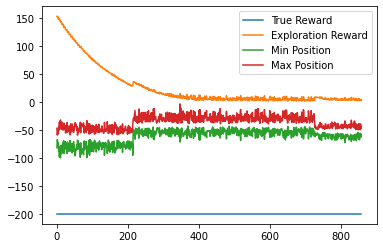

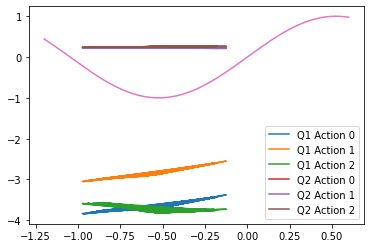

Episode:  860, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0101, LossQ2: 0.0043, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  861, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0062, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  862, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.0053, LossQ2: 0.0019, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  863, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.7901, LossQ2: 0.0038, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  864, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0071, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  865, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0074, LossQ2: 0.0031, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  866, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0081, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  867, Reward: -200.0, Expl. Reward:  7.0, LossQ1: 0.9106, LossQ2: 0.0024, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  868, Reward: -

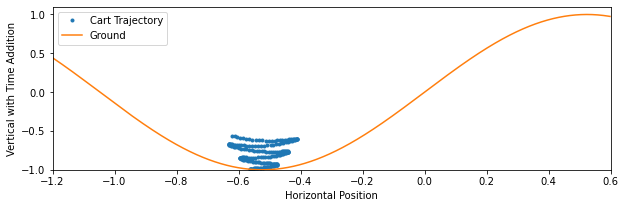

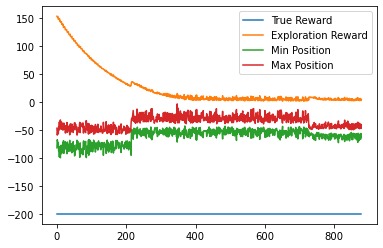

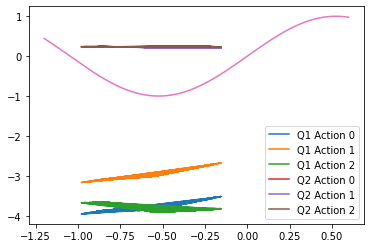

Episode:  880, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0065, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  881, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0084, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  882, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.0070, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  883, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.0063, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  884, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0061, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  885, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0057, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  886, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0055, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  887, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.8448, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  888, Reward: -

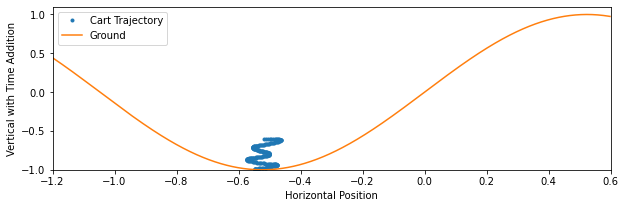

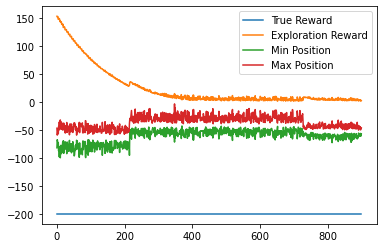

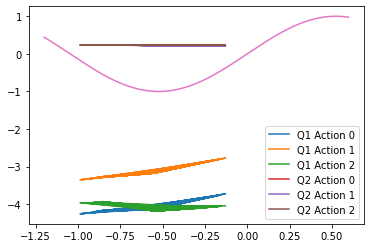

Episode:  900, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.7866, LossQ2: 0.0025, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode:  901, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0162, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  902, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0080, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  903, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.0078, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  904, Reward: -200.0, Expl. Reward:  7.1, LossQ1: 0.9852, LossQ2: 0.0023, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  905, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.7606, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  906, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0199, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  907, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0086, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  908, Reward: -

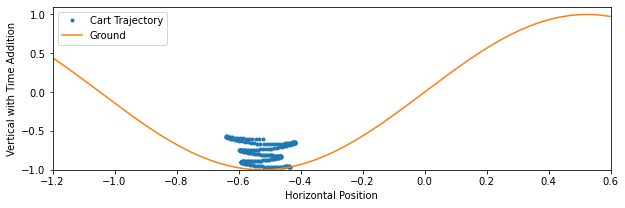

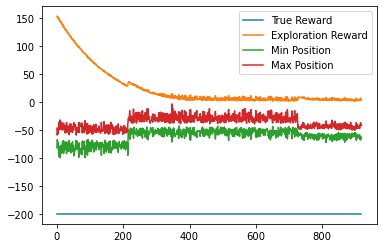

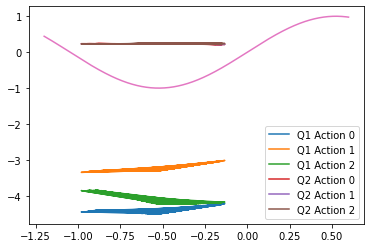

Episode:  920, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.8698, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  921, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.0173, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  922, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0075, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  923, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0048, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  924, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.1371, LossQ2: 0.0033, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  925, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.8493, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  926, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0544, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  927, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0358, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  928, Reward: -

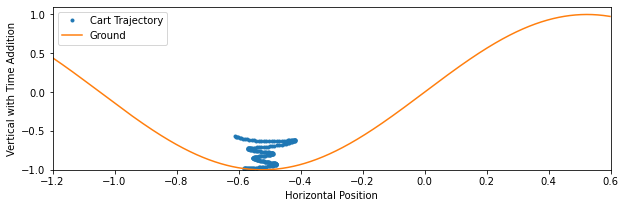

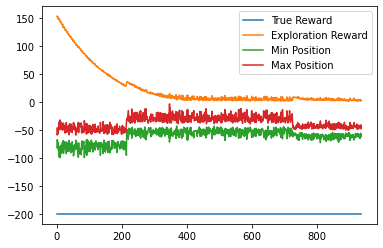

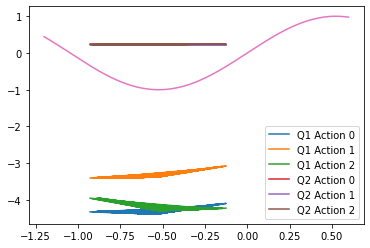

Episode:  940, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.8621, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  941, Reward: -200.0, Expl. Reward:  1.4, LossQ1: 0.0040, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  942, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0077, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  943, Reward: -200.0, Expl. Reward:  7.6, LossQ1: 0.0039, LossQ2: 0.0017, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  944, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0059, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  945, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0034, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  946, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.0040, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  947, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.8345, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  948, Reward: -

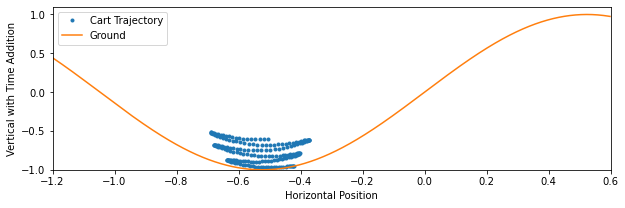

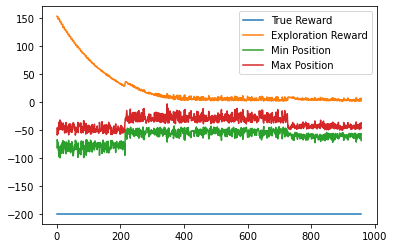

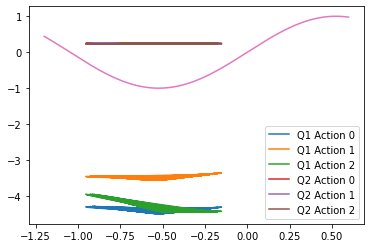

Episode:  960, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0012, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  961, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.0015, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  962, Reward: -200.0, Expl. Reward:  1.4, LossQ1: 0.8489, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  963, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.0018, LossQ2: 0.0021, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode:  964, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.8755, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  965, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0016, LossQ2: 0.0029, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  966, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0017, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  967, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.8752, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  968, Reward: -

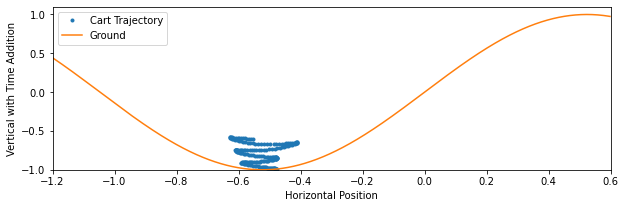

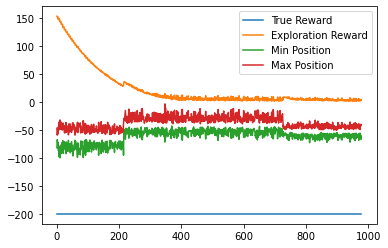

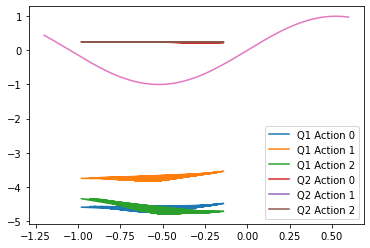

Episode:  980, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0057, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  981, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0047, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  982, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.8099, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  983, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0060, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  984, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.8005, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  985, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.0071, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode:  986, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0190, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  987, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.0100, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode:  988, Reward: -

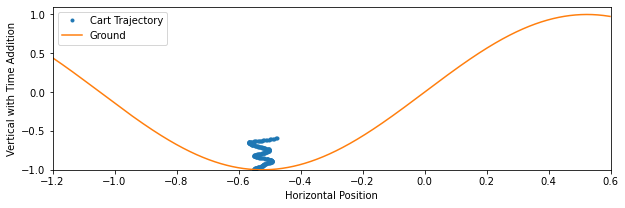

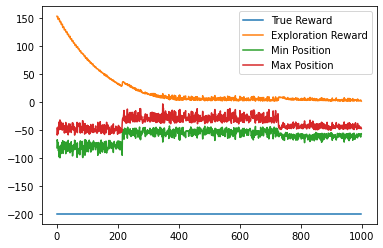

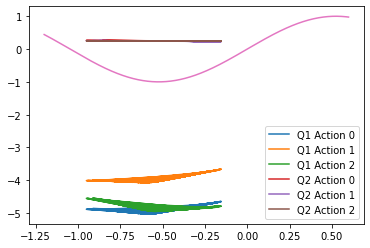

Episode: 1000, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0066, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1001, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0371, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1002, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0084, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1003, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0658, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1004, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.9539, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1005, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0149, LossQ2: 0.0015, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1006, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.7842, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1007, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.8134, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1008, Reward: -

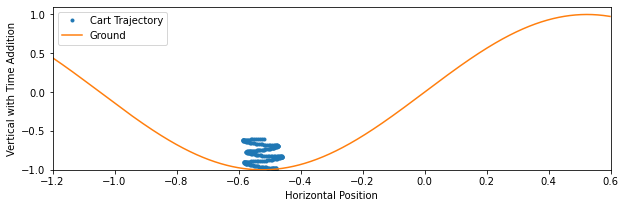

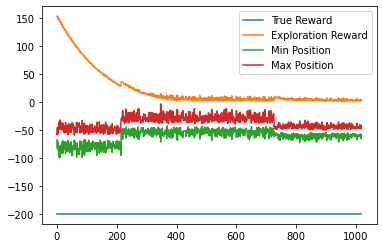

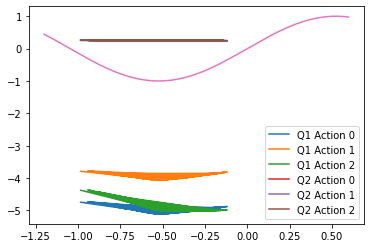

Episode: 1020, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.0036, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1021, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0135, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1022, Reward: -200.0, Expl. Reward:  1.2, LossQ1: 0.0065, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1023, Reward: -200.0, Expl. Reward:  8.0, LossQ1: 0.0025, LossQ2: 0.0013, MinPos: -0.7, MaxPos: -0.3, Alpha: 1.0
Episode: 1024, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0066, LossQ2: 0.0021, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1025, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0044, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1026, Reward: -200.0, Expl. Reward:  1.1, LossQ1: 0.0054, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1027, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.0062, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1028, Reward: -

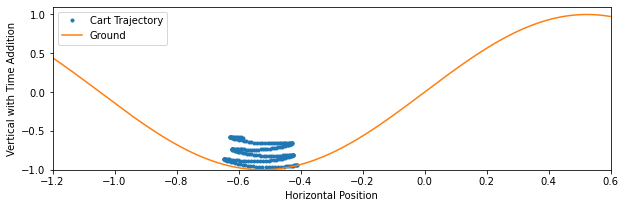

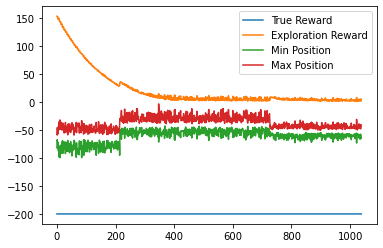

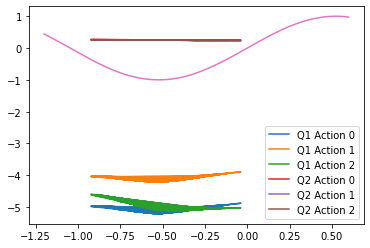

Episode: 1040, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.8472, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1041, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.8533, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1042, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.0081, LossQ2: 0.0019, MinPos: -0.7, MaxPos: -0.3, Alpha: 1.0
Episode: 1043, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.8348, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1044, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0093, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1045, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0042, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1046, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.8391, LossQ2: 0.0020, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1047, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0158, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1048, Reward: -

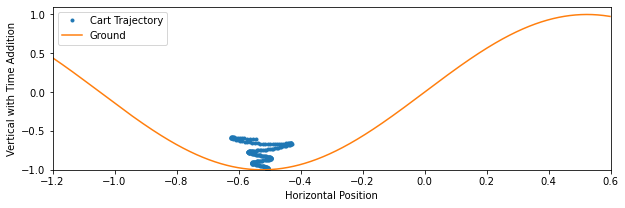

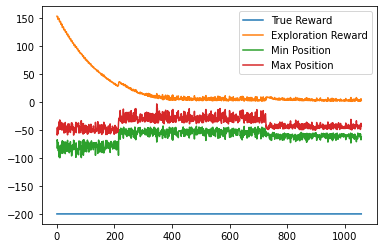

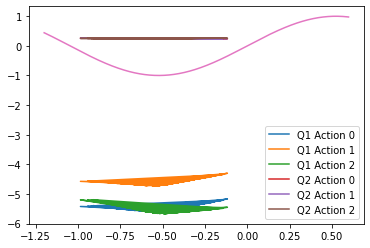

Episode: 1060, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0085, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1061, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0071, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1062, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0055, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1063, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0040, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1064, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0055, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1065, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0076, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1066, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0067, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1067, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0212, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1068, Reward: -

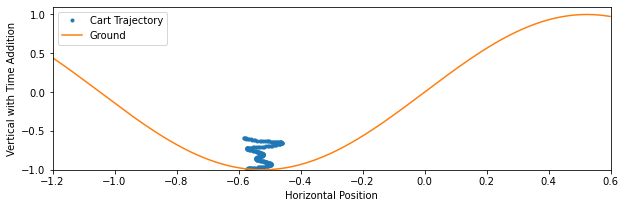

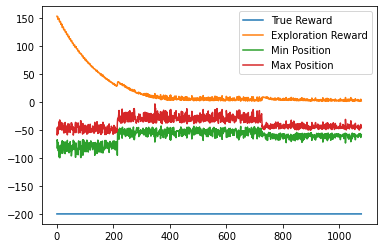

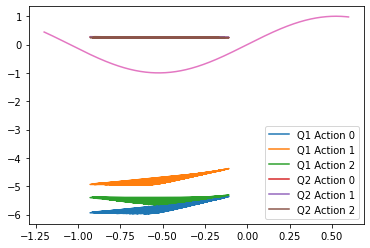

Episode: 1080, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0700, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1081, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0383, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1082, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0284, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1083, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0279, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1084, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0190, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1085, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.0246, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1086, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.0317, LossQ2: 0.0025, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1087, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0232, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1088, Reward: -

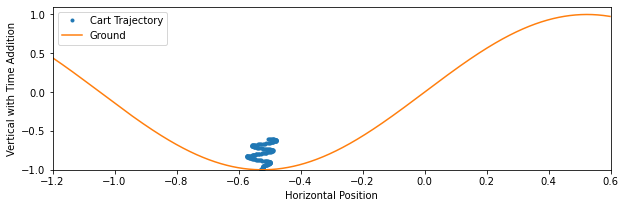

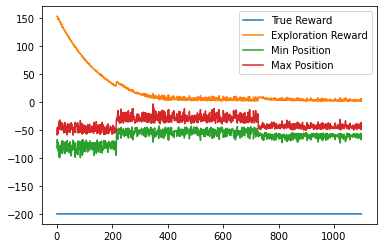

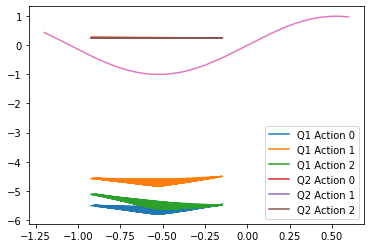

Episode: 1100, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0230, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1101, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.7943, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1102, Reward: -200.0, Expl. Reward:  1.0, LossQ1: 0.0176, LossQ2: 0.0025, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode: 1103, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.9691, LossQ2: 0.0019, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1104, Reward: -200.0, Expl. Reward:  1.3, LossQ1: 0.8257, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1105, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0274, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1106, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0136, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1107, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.8391, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1108, Reward: -

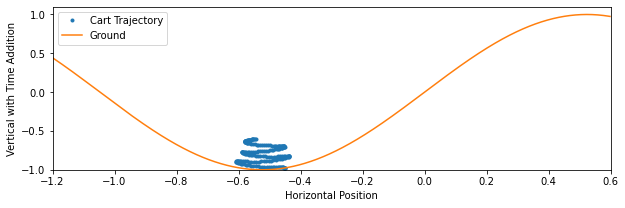

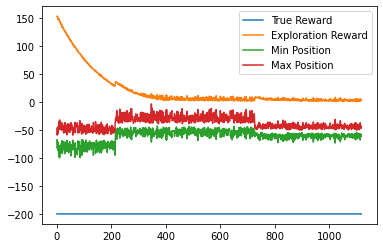

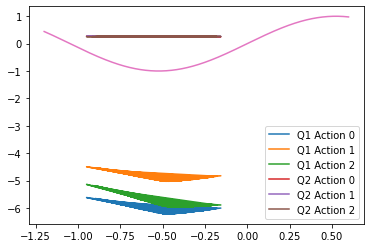

Episode: 1120, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.9222, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1121, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.1112, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1122, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0474, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1123, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.0673, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1124, Reward: -200.0, Expl. Reward:  1.3, LossQ1: 0.0324, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1125, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0406, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1126, Reward: -200.0, Expl. Reward:  1.4, LossQ1: 0.7653, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1127, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0858, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1128, Reward: -

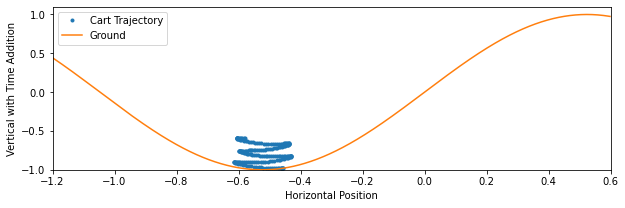

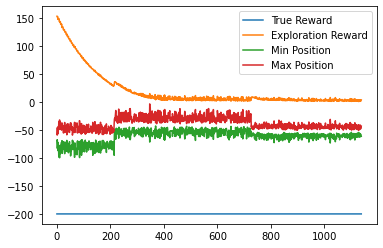

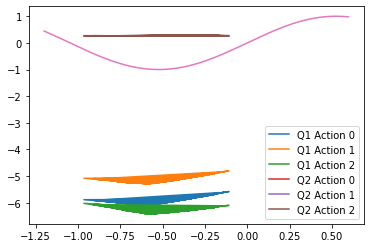

Episode: 1140, Reward: -200.0, Expl. Reward:  1.2, LossQ1: 0.7580, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1141, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.9423, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1142, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.7954, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1143, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0810, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1144, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.7024, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1145, Reward: -200.0, Expl. Reward:  0.9, LossQ1: 0.0378, LossQ2: 0.0013, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode: 1146, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.6551, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1147, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.1512, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1148, Reward: -

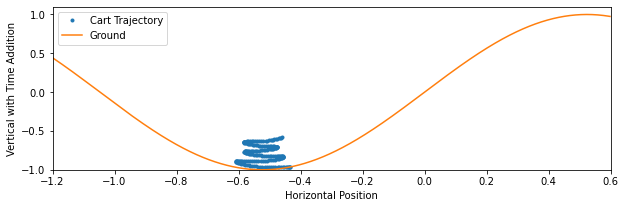

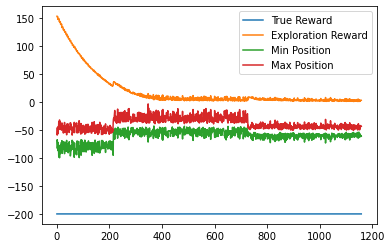

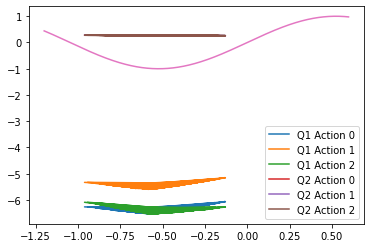

Episode: 1160, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0096, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1161, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0502, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1162, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0088, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1163, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0027, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1164, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0044, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1165, Reward: -200.0, Expl. Reward:  1.1, LossQ1: 0.9428, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1166, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0098, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1167, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.0050, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1168, Reward: -

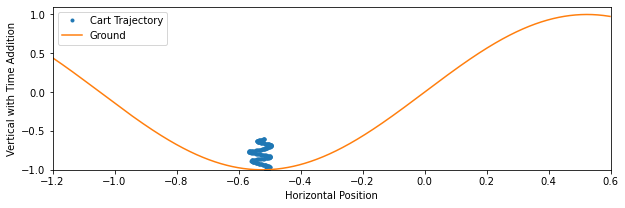

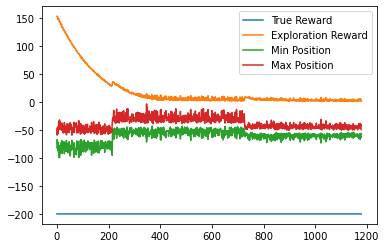

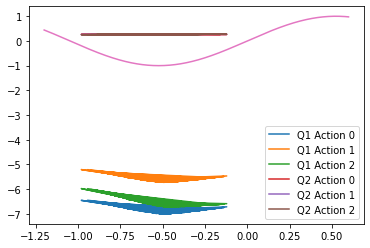

Episode: 1180, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.0086, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1181, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.1902, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1182, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.8075, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1183, Reward: -200.0, Expl. Reward:  1.3, LossQ1: 0.8236, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1184, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.8923, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1185, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0331, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1186, Reward: -200.0, Expl. Reward:  1.9, LossQ1: 0.8859, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1187, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.1300, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1188, Reward: -

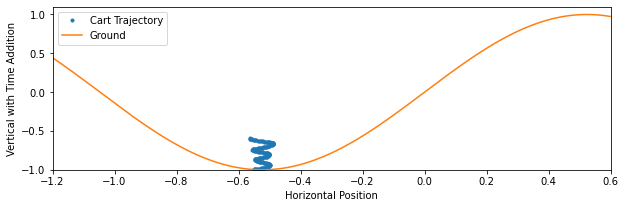

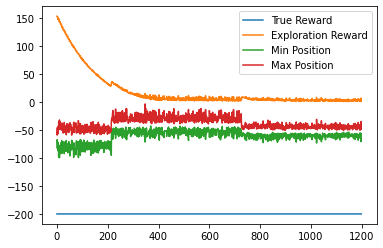

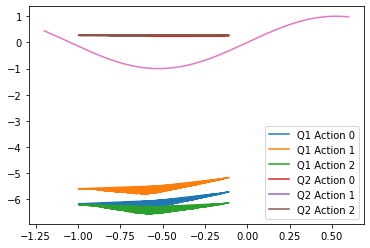

Episode: 1200, Reward: -200.0, Expl. Reward:  0.7, LossQ1: 0.0933, LossQ2: 0.0012, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode: 1201, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.7044, LossQ2: 0.0013, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1202, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 1.2373, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1203, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.7259, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1204, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.6633, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1205, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0426, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1206, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0297, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1207, Reward: -200.0, Expl. Reward:  6.6, LossQ1: 0.0293, LossQ2: 0.0013, MinPos: -0.7, MaxPos: -0.3, Alpha: 1.0
Episode: 1208, Reward: -

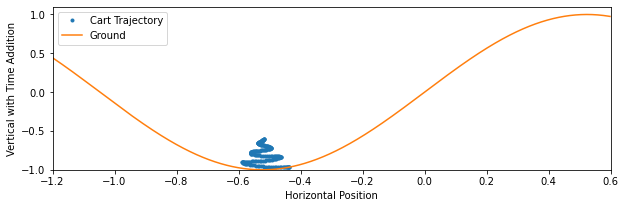

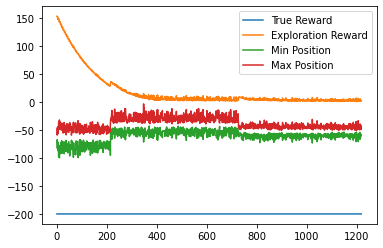

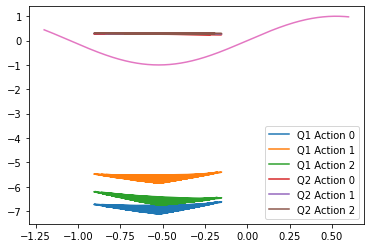

Episode: 1220, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.1631, LossQ2: 0.0038, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1221, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.7842, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1222, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.7803, LossQ2: 0.0011, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1223, Reward: -200.0, Expl. Reward:  1.0, LossQ1: 0.7763, LossQ2: 0.0014, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode: 1224, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.0253, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1225, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.0440, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1226, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0111, LossQ2: 0.0009, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1227, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 1.0585, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1228, Reward: -

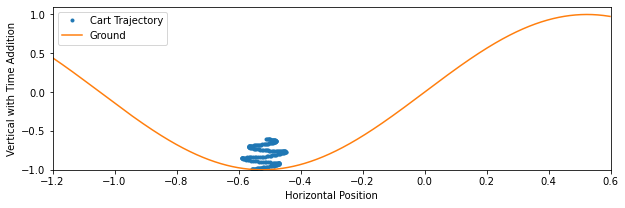

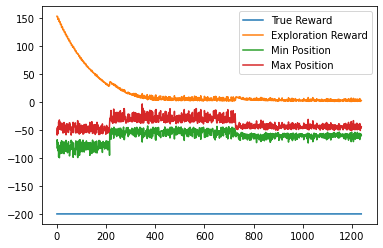

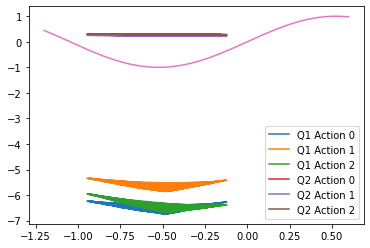

Episode: 1240, Reward: -200.0, Expl. Reward:  1.4, LossQ1: 0.7651, LossQ2: 0.0048, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1241, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0513, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1242, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0148, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1243, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0572, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1244, Reward: -200.0, Expl. Reward:  3.9, LossQ1: 0.0245, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1245, Reward: -200.0, Expl. Reward:  1.3, LossQ1: 0.7887, LossQ2: 0.0012, MinPos: -0.5, MaxPos: -0.5, Alpha: 1.0
Episode: 1246, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.8919, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1247, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0438, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1248, Reward: -

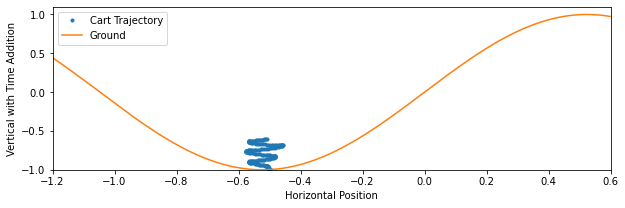

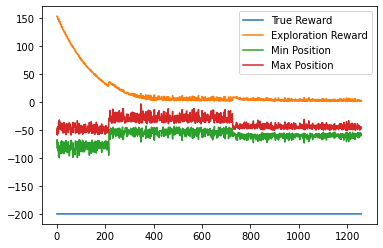

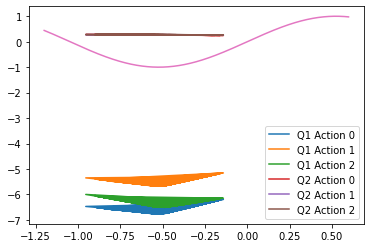

Episode: 1260, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.0113, LossQ2: 0.0008, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1261, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.0079, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1262, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.7813, LossQ2: 0.0017, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1263, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.8743, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1264, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.0175, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1265, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0251, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1266, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0072, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1267, Reward: -200.0, Expl. Reward:  1.2, LossQ1: 0.0125, LossQ2: 0.0028, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1268, Reward: -

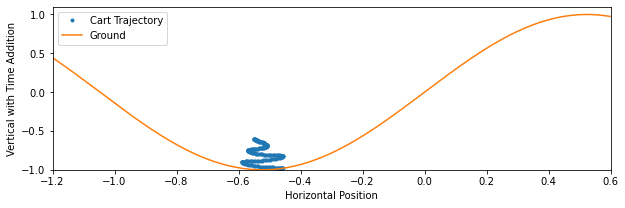

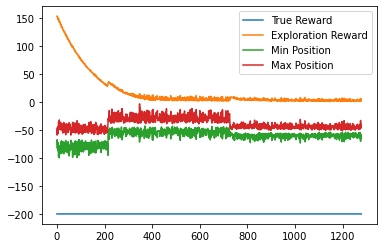

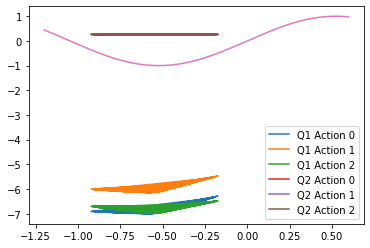

Episode: 1280, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.0546, LossQ2: 0.0022, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1281, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7817, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1282, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.1581, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1283, Reward: -200.0, Expl. Reward:  3.9, LossQ1: 0.0552, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1284, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.6800, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1285, Reward: -200.0, Expl. Reward:  2.9, LossQ1: 0.0602, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1286, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.7483, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1287, Reward: -200.0, Expl. Reward:  3.9, LossQ1: 0.7721, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1288, Reward: -

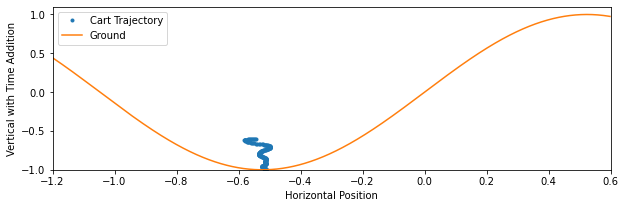

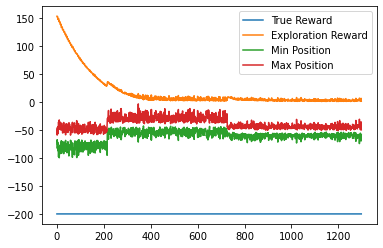

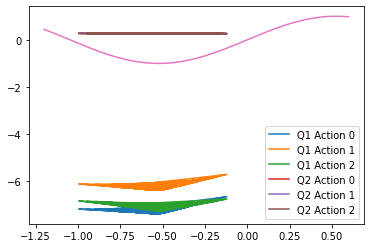

Episode: 1300, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0342, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1301, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.0596, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1302, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.8305, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1303, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.7383, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1304, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0176, LossQ2: 0.0011, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1305, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0284, LossQ2: 0.0034, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1306, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.0820, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1307, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0356, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1308, Reward: -

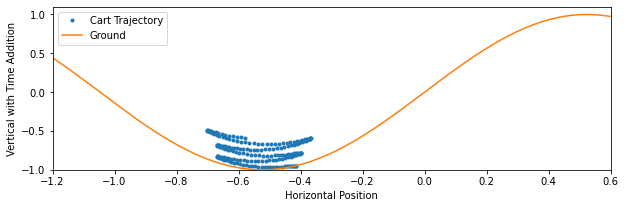

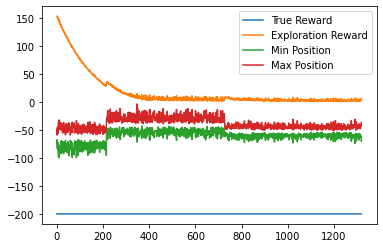

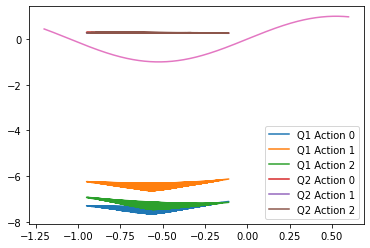

Episode: 1320, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 1.2509, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1321, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.7137, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1322, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0790, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1323, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0242, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1324, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.0079, LossQ2: 0.0012, MinPos: -0.7, MaxPos: -0.4, Alpha: 1.0
Episode: 1325, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.8121, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1326, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.7965, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1327, Reward: -200.0, Expl. Reward:  1.6, LossQ1: 0.0191, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1328, Reward: -

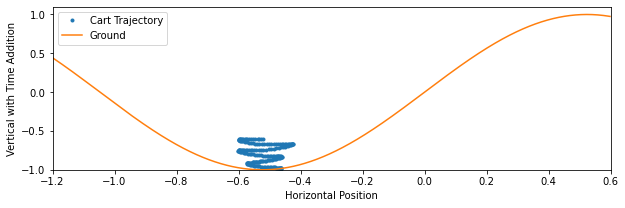

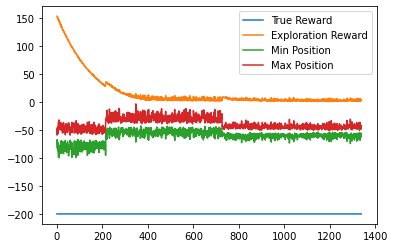

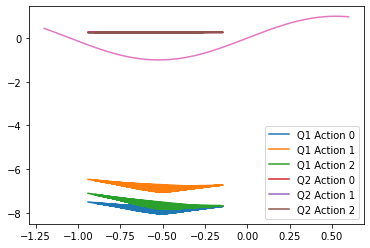

Episode: 1340, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0137, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1341, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0081, LossQ2: 0.0011, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1342, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.7685, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1343, Reward: -200.0, Expl. Reward:  1.7, LossQ1: 0.8548, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1344, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.8290, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1345, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0221, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1346, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7630, LossQ2: 0.0009, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1347, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.8592, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1348, Reward: -

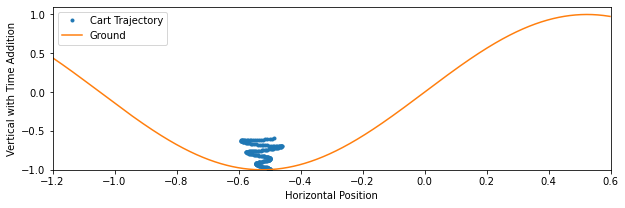

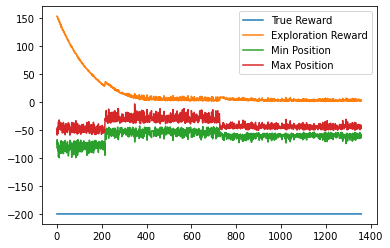

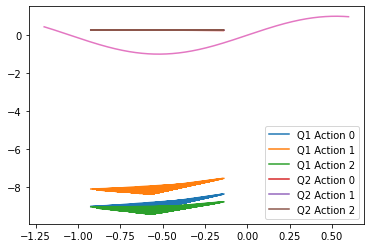

Episode: 1360, Reward: -200.0, Expl. Reward:  2.9, LossQ1: 1.0547, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1361, Reward: -200.0, Expl. Reward:  1.2, LossQ1: 0.0921, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1362, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0248, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1363, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.0336, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1364, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.1007, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1365, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0149, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1366, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.7936, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.4, Alpha: 1.0
Episode: 1367, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.6096, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.5, Alpha: 1.0
Episode: 1368, Reward: -

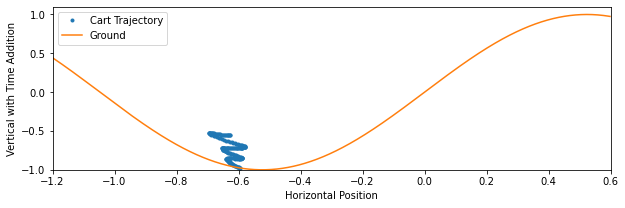

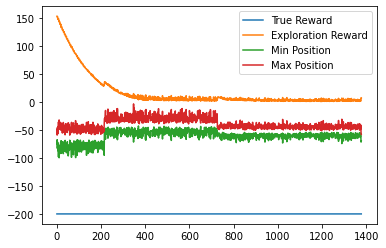

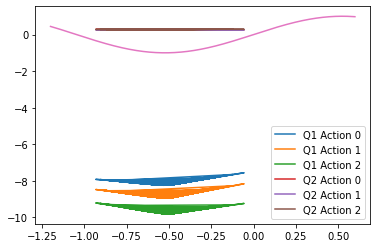

Episode: 1380, Reward: -200.0, Expl. Reward: 12.4, LossQ1: 0.4723, LossQ2: 0.0011, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1381, Reward: -200.0, Expl. Reward: 16.7, LossQ1: 0.0658, LossQ2: 0.0011, MinPos: -1.1, MaxPos: -0.2, Alpha: 1.0
Episode: 1382, Reward: -200.0, Expl. Reward: 11.6, LossQ1: 0.0201, LossQ2: 0.0013, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1383, Reward: -200.0, Expl. Reward: 12.8, LossQ1: 0.0106, LossQ2: 0.0026, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1384, Reward: -200.0, Expl. Reward: 11.3, LossQ1: 0.6915, LossQ2: 0.0011, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1385, Reward: -200.0, Expl. Reward:  8.7, LossQ1: 0.7724, LossQ2: 0.0010, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1386, Reward: -200.0, Expl. Reward: 12.1, LossQ1: 0.1152, LossQ2: 0.0013, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1387, Reward: -200.0, Expl. Reward:  9.8, LossQ1: 0.2812, LossQ2: 0.0023, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1388, Reward: -

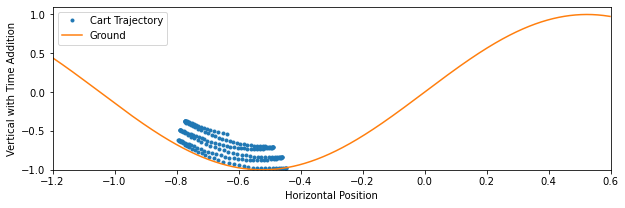

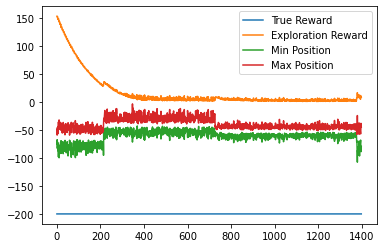

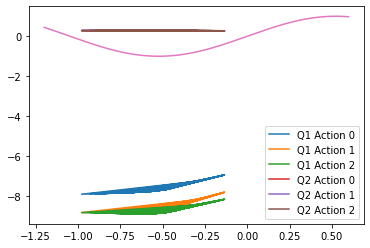

Episode: 1400, Reward: -200.0, Expl. Reward:  8.6, LossQ1: 0.0274, LossQ2: 0.0021, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1401, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0339, LossQ2: 0.0017, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1402, Reward: -200.0, Expl. Reward:  9.5, LossQ1: 0.0926, LossQ2: 0.0017, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1403, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0360, LossQ2: 0.0016, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1404, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0343, LossQ2: 0.0015, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1405, Reward: -200.0, Expl. Reward: 10.7, LossQ1: 0.0988, LossQ2: 0.0019, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1406, Reward: -200.0, Expl. Reward: 10.1, LossQ1: 0.7841, LossQ2: 0.0027, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1407, Reward: -200.0, Expl. Reward:  6.8, LossQ1: 0.0119, LossQ2: 0.0015, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1408, Reward: -

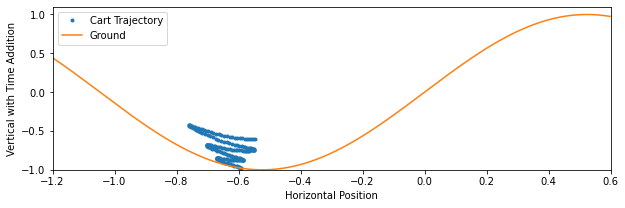

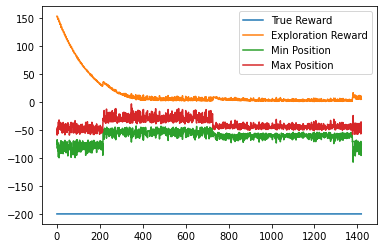

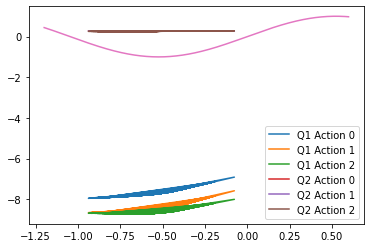

Episode: 1420, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0307, LossQ2: 0.0039, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1421, Reward: -200.0, Expl. Reward:  6.6, LossQ1: 0.0460, LossQ2: 0.0024, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1422, Reward: -200.0, Expl. Reward: 11.1, LossQ1: 0.5260, LossQ2: 0.0061, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1423, Reward: -200.0, Expl. Reward: 11.0, LossQ1: 0.1615, LossQ2: 0.0026, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1424, Reward: -200.0, Expl. Reward:  8.0, LossQ1: 0.0271, LossQ2: 0.0036, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1425, Reward: -200.0, Expl. Reward: 10.0, LossQ1: 0.0640, LossQ2: 0.0031, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1426, Reward: -200.0, Expl. Reward: 10.2, LossQ1: 0.0676, LossQ2: 0.0040, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1427, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.9326, LossQ2: 0.0083, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1428, Reward: -

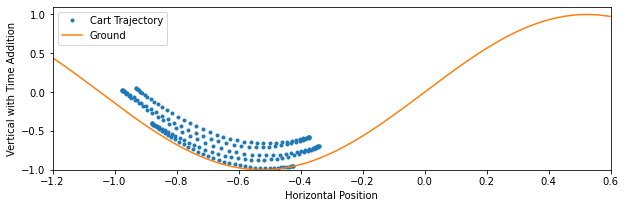

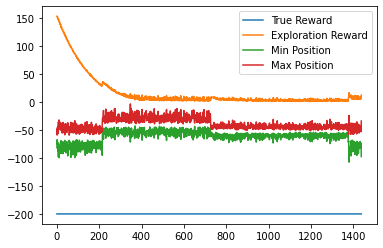

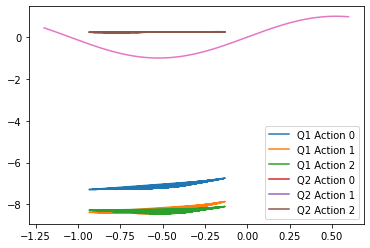

Episode: 1440, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 0.7618, LossQ2: 0.0042, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1441, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.3055, LossQ2: 0.0059, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1442, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.2246, LossQ2: 0.0060, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1443, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0110, LossQ2: 0.0056, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1444, Reward: -200.0, Expl. Reward:  9.2, LossQ1: 0.7556, LossQ2: 0.0038, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1445, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.1864, LossQ2: 0.0039, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1446, Reward: -200.0, Expl. Reward:  6.5, LossQ1: 0.7546, LossQ2: 0.0043, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1447, Reward: -200.0, Expl. Reward:  8.3, LossQ1: 0.0789, LossQ2: 0.0040, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1448, Reward: -

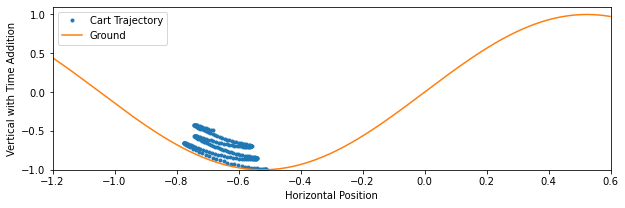

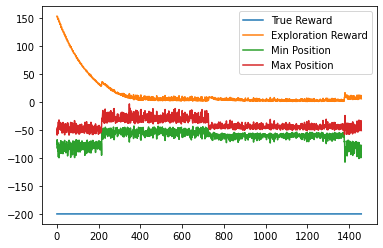

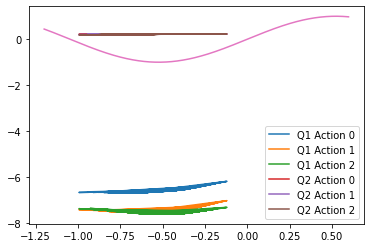

Episode: 1460, Reward: -200.0, Expl. Reward: 11.9, LossQ1: 0.0079, LossQ2: 0.0043, MinPos: -1.0, MaxPos: -0.3, Alpha: 1.0
Episode: 1461, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0093, LossQ2: 0.0040, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1462, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.7204, LossQ2: 0.0056, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1463, Reward: -200.0, Expl. Reward:  6.6, LossQ1: 0.7219, LossQ2: 0.0045, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1464, Reward: -200.0, Expl. Reward: 12.3, LossQ1: 0.6616, LossQ2: 0.0040, MinPos: -1.0, MaxPos: -0.3, Alpha: 1.0
Episode: 1465, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 1.0005, LossQ2: 0.0045, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1466, Reward: -200.0, Expl. Reward:  7.6, LossQ1: 0.9411, LossQ2: 0.0046, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1467, Reward: -200.0, Expl. Reward:  8.3, LossQ1: 0.0123, LossQ2: 0.0040, MinPos: -0.9, MaxPos: -0.5, Alpha: 1.0
Episode: 1468, Reward: -

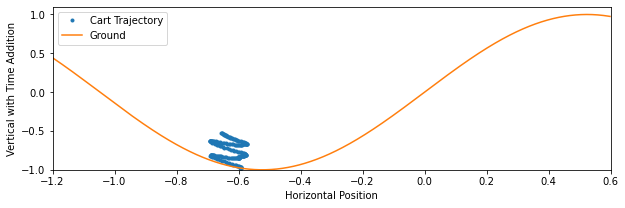

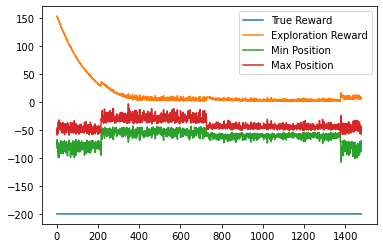

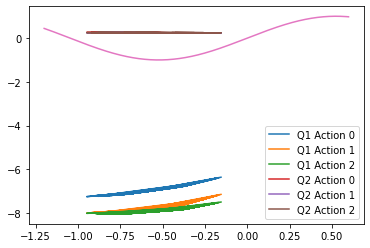

Episode: 1480, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0206, LossQ2: 0.0037, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1481, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.0188, LossQ2: 0.0039, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1482, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.5401, LossQ2: 0.0035, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1483, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.0251, LossQ2: 0.0040, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1484, Reward: -200.0, Expl. Reward: 11.5, LossQ1: 0.0252, LossQ2: 0.0035, MinPos: -0.9, MaxPos: -0.3, Alpha: 1.0
Episode: 1485, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.7536, LossQ2: 0.0032, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1486, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.4954, LossQ2: 0.0033, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1487, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0145, LossQ2: 0.0036, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1488, Reward: -

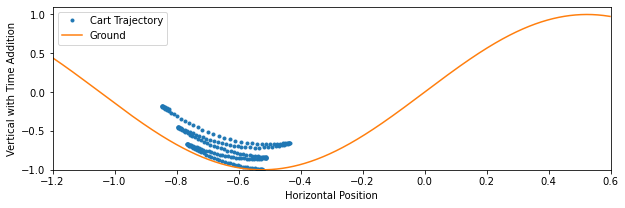

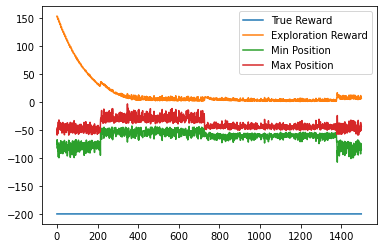

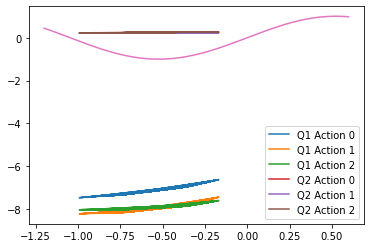

Episode: 1500, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0302, LossQ2: 0.0031, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1501, Reward: -200.0, Expl. Reward:  8.4, LossQ1: 0.6536, LossQ2: 0.0035, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1502, Reward: -200.0, Expl. Reward:  6.6, LossQ1: 0.8613, LossQ2: 0.0033, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1503, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.5924, LossQ2: 0.0034, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1504, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0146, LossQ2: 0.0033, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1505, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0148, LossQ2: 0.0050, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1506, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0158, LossQ2: 0.0040, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1507, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.5575, LossQ2: 0.0036, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1508, Reward: -

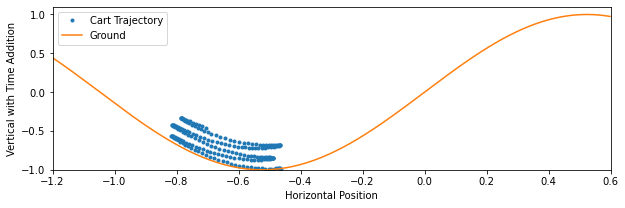

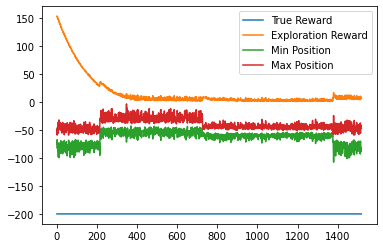

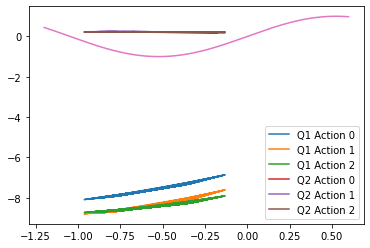

Episode: 1520, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0377, LossQ2: 0.0026, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1521, Reward: -200.0, Expl. Reward:  7.6, LossQ1: 0.3136, LossQ2: 0.0065, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1522, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.0381, LossQ2: 0.0073, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1523, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0564, LossQ2: 0.0066, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1524, Reward: -200.0, Expl. Reward:  6.5, LossQ1: 0.0389, LossQ2: 0.0045, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1525, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0475, LossQ2: 0.0025, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1526, Reward: -200.0, Expl. Reward:  9.6, LossQ1: 0.0217, LossQ2: 0.0019, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1527, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.0280, LossQ2: 0.0026, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1528, Reward: -

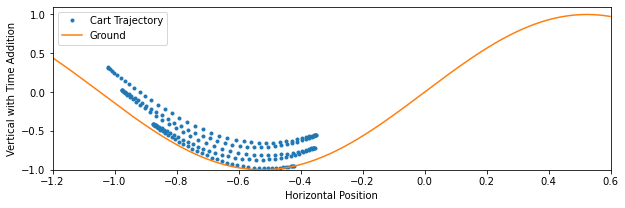

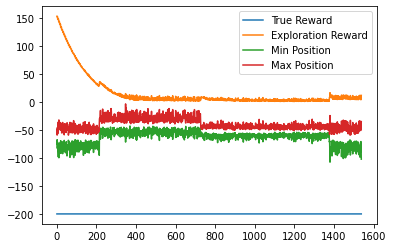

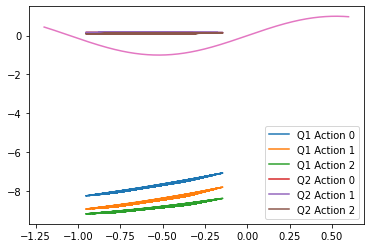

Episode: 1540, Reward: -200.0, Expl. Reward:  8.2, LossQ1: 0.0481, LossQ2: 0.0025, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1541, Reward: -200.0, Expl. Reward:  7.0, LossQ1: 0.0398, LossQ2: 0.0025, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1542, Reward: -200.0, Expl. Reward: 10.1, LossQ1: 1.2237, LossQ2: 0.0025, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1543, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.0414, LossQ2: 0.0043, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1544, Reward: -200.0, Expl. Reward:  7.5, LossQ1: 0.0538, LossQ2: 0.0045, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1545, Reward: -200.0, Expl. Reward:  6.6, LossQ1: 0.3791, LossQ2: 0.0036, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1546, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.0403, LossQ2: 0.0028, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1547, Reward: -200.0, Expl. Reward:  8.5, LossQ1: 0.9676, LossQ2: 0.0048, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1548, Reward: -

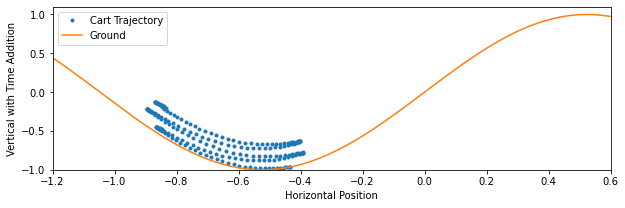

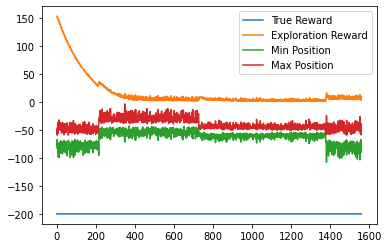

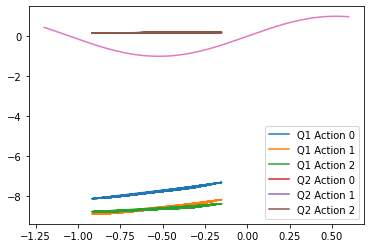

Episode: 1560, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.4846, LossQ2: 0.0035, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1561, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 1.2563, LossQ2: 0.0037, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1562, Reward: -200.0, Expl. Reward:  9.9, LossQ1: 0.4677, LossQ2: 0.0023, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1563, Reward: -200.0, Expl. Reward:  8.7, LossQ1: 0.0358, LossQ2: 0.0030, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1564, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.6228, LossQ2: 0.0025, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1565, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0195, LossQ2: 0.0038, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1566, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.0146, LossQ2: 0.0033, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1567, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0158, LossQ2: 0.0030, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1568, Reward: -

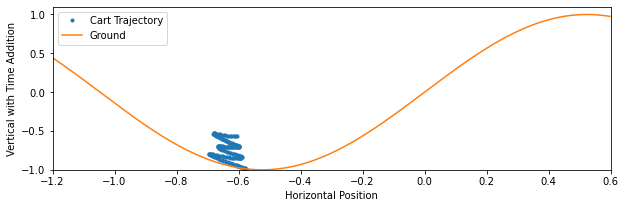

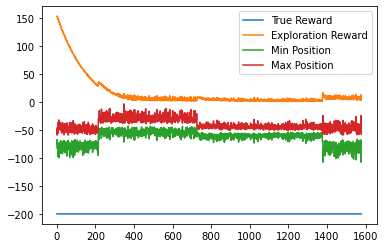

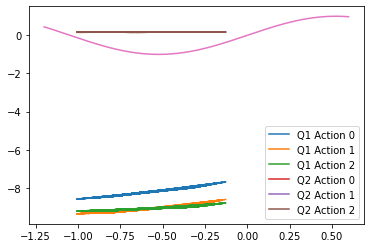

Episode: 1580, Reward: -200.0, Expl. Reward:  7.6, LossQ1: 0.0188, LossQ2: 0.0023, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1581, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0194, LossQ2: 0.0028, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1582, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0146, LossQ2: 0.0029, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1583, Reward: -200.0, Expl. Reward:  6.5, LossQ1: 0.0258, LossQ2: 0.0029, MinPos: -0.9, MaxPos: -0.5, Alpha: 1.0
Episode: 1584, Reward: -200.0, Expl. Reward: 12.5, LossQ1: 0.0215, LossQ2: 0.0021, MinPos: -1.1, MaxPos: -0.3, Alpha: 1.0
Episode: 1585, Reward: -200.0, Expl. Reward:  7.1, LossQ1: 0.0117, LossQ2: 0.0031, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1586, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.0171, LossQ2: 0.0025, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1587, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.4328, LossQ2: 0.0023, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1588, Reward: -

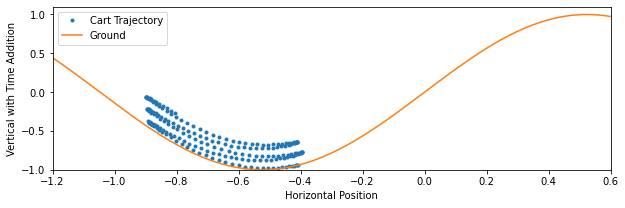

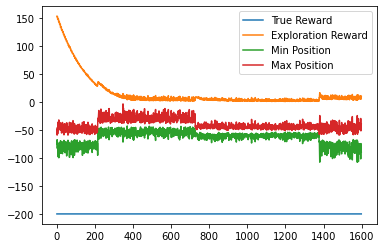

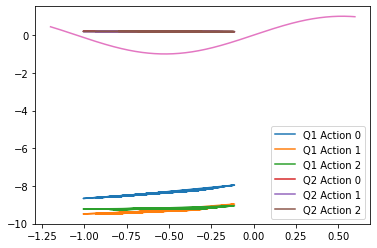

Episode: 1600, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0073, LossQ2: 0.0023, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1601, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.5577, LossQ2: 0.0026, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1602, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.7029, LossQ2: 0.0024, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1603, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.5092, LossQ2: 0.0017, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1604, Reward: -200.0, Expl. Reward:  9.7, LossQ1: 0.6038, LossQ2: 0.0018, MinPos: -1.0, MaxPos: -0.4, Alpha: 1.0
Episode: 1605, Reward: -200.0, Expl. Reward: 10.4, LossQ1: 0.0308, LossQ2: 0.0026, MinPos: -1.0, MaxPos: -0.4, Alpha: 1.0
Episode: 1606, Reward: -200.0, Expl. Reward:  5.5, LossQ1: 0.0279, LossQ2: 0.0037, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1607, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.9419, LossQ2: 0.0034, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1608, Reward: -

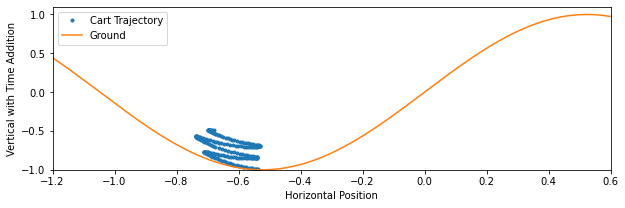

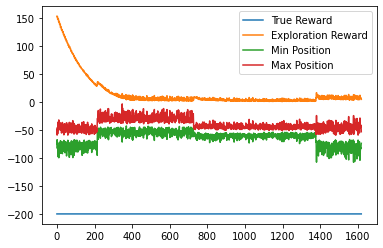

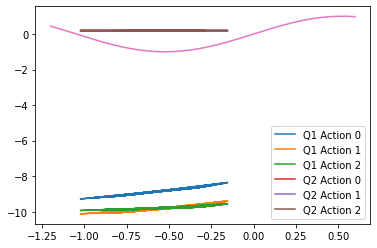

Episode: 1620, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0178, LossQ2: 0.0023, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1621, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 1.3339, LossQ2: 0.0026, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1622, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0234, LossQ2: 0.0028, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1623, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.7435, LossQ2: 0.0024, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1624, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.0649, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1625, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0201, LossQ2: 0.0022, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1626, Reward: -200.0, Expl. Reward:  9.1, LossQ1: 0.7929, LossQ2: 0.0024, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1627, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0147, LossQ2: 0.0034, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1628, Reward: -

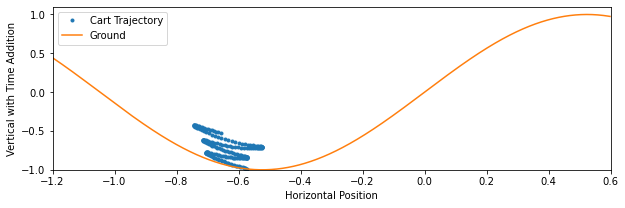

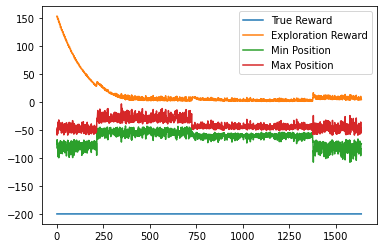

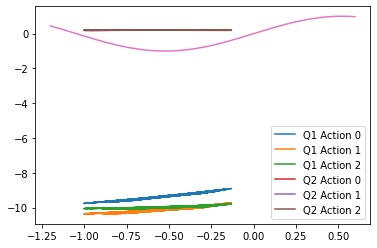

Episode: 1640, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0253, LossQ2: 0.0020, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1641, Reward: -200.0, Expl. Reward:  6.7, LossQ1: 0.0692, LossQ2: 0.0022, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1642, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.3710, LossQ2: 0.0021, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1643, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.6153, LossQ2: 0.0019, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1644, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7678, LossQ2: 0.0020, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1645, Reward: -200.0, Expl. Reward:  5.9, LossQ1: 0.0331, LossQ2: 0.0019, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1646, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0613, LossQ2: 0.0022, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1647, Reward: -200.0, Expl. Reward:  9.9, LossQ1: 0.0627, LossQ2: 0.0017, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1648, Reward: -

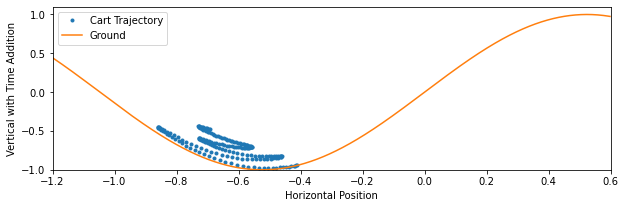

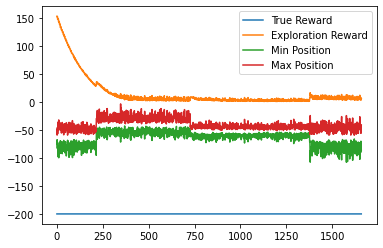

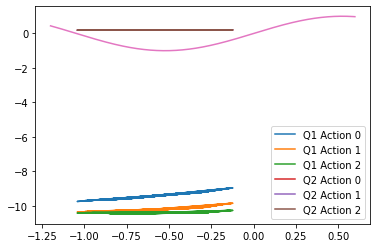

Episode: 1660, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.8227, LossQ2: 0.0018, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1661, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.0232, LossQ2: 0.0022, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1662, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.8357, LossQ2: 0.0022, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1663, Reward: -200.0, Expl. Reward:  6.5, LossQ1: 0.0093, LossQ2: 0.0020, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1664, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.6613, LossQ2: 0.0030, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1665, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.0075, LossQ2: 0.0017, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1666, Reward: -200.0, Expl. Reward:  8.0, LossQ1: 0.0080, LossQ2: 0.0020, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1667, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.8215, LossQ2: 0.0021, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1668, Reward: -

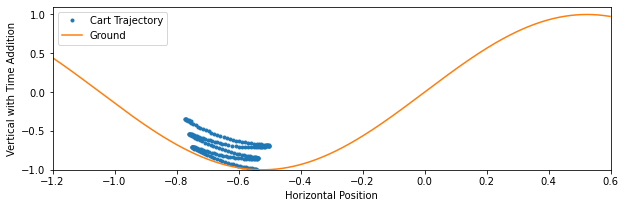

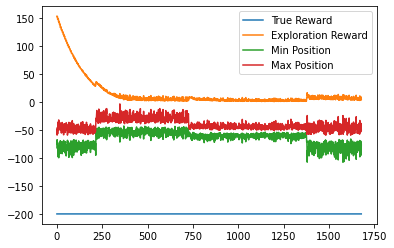

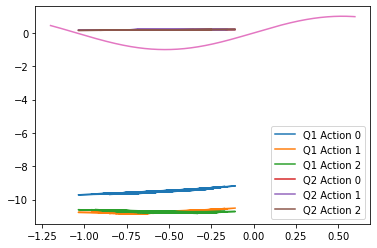

Episode: 1680, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.7224, LossQ2: 0.0024, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1681, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.0043, LossQ2: 0.0013, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1682, Reward: -200.0, Expl. Reward:  5.5, LossQ1: 0.0285, LossQ2: 0.0018, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1683, Reward: -200.0, Expl. Reward:  8.2, LossQ1: 0.0225, LossQ2: 0.0036, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1684, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0284, LossQ2: 0.0014, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1685, Reward: -200.0, Expl. Reward:  7.7, LossQ1: 0.0170, LossQ2: 0.0032, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1686, Reward: -200.0, Expl. Reward:  4.3, LossQ1: 0.7028, LossQ2: 0.0020, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1687, Reward: -200.0, Expl. Reward:  5.8, LossQ1: 0.0136, LossQ2: 0.0013, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1688, Reward: -

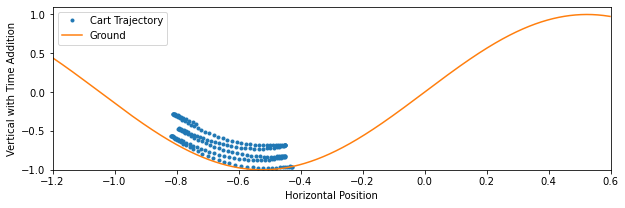

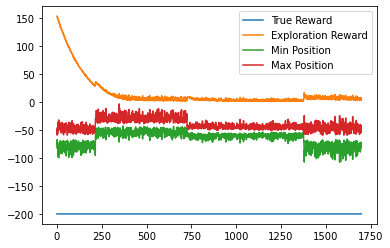

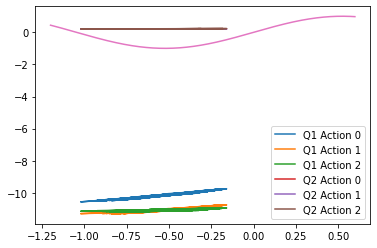

Episode: 1700, Reward: -200.0, Expl. Reward:  8.2, LossQ1: 0.0180, LossQ2: 0.0021, MinPos: -0.9, MaxPos: -0.3, Alpha: 1.0
Episode: 1701, Reward: -200.0, Expl. Reward:  7.8, LossQ1: 0.3568, LossQ2: 0.0015, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1702, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.0223, LossQ2: 0.0015, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1703, Reward: -200.0, Expl. Reward:  9.4, LossQ1: 0.5172, LossQ2: 0.0019, MinPos: -1.0, MaxPos: -0.4, Alpha: 1.0
Episode: 1704, Reward: -200.0, Expl. Reward:  8.2, LossQ1: 0.0306, LossQ2: 0.0018, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1705, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.4140, LossQ2: 0.0020, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1706, Reward: -200.0, Expl. Reward:  8.8, LossQ1: 0.0324, LossQ2: 0.0015, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1707, Reward: -200.0, Expl. Reward:  9.2, LossQ1: 0.0321, LossQ2: 0.0016, MinPos: -1.0, MaxPos: -0.3, Alpha: 1.0
Episode: 1708, Reward: -

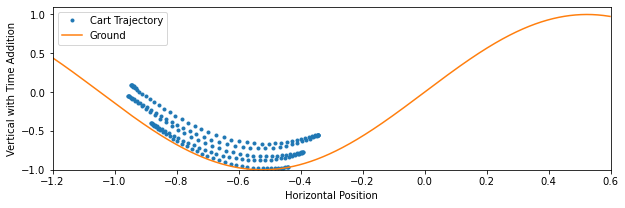

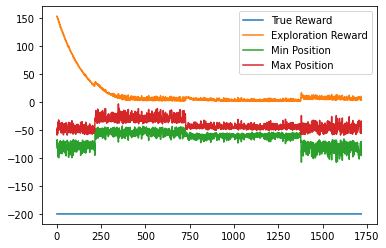

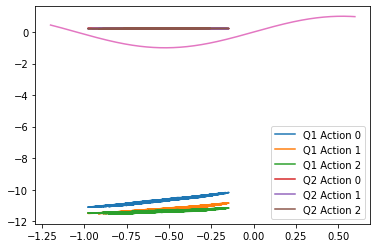

Episode: 1720, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.0307, LossQ2: 0.0015, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1721, Reward: -200.0, Expl. Reward:  7.4, LossQ1: 0.1029, LossQ2: 0.0014, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1722, Reward: -200.0, Expl. Reward:  6.8, LossQ1: 0.0407, LossQ2: 0.0027, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1723, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.0509, LossQ2: 0.0019, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1724, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.5746, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1725, Reward: -200.0, Expl. Reward:  8.7, LossQ1: 0.0380, LossQ2: 0.0019, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1726, Reward: -200.0, Expl. Reward:  8.1, LossQ1: 0.9473, LossQ2: 0.0021, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1727, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0275, LossQ2: 0.0016, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1728, Reward: -

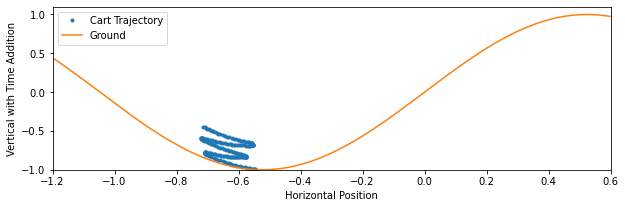

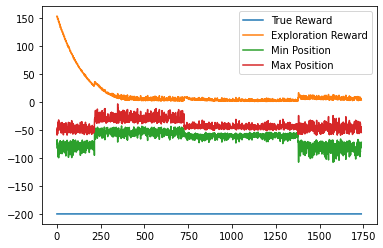

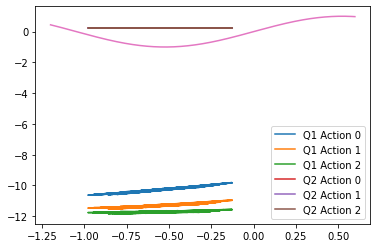

Episode: 1740, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.1183, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1741, Reward: -200.0, Expl. Reward:  6.0, LossQ1: 0.6802, LossQ2: 0.0016, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1742, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.0783, LossQ2: 0.0014, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1743, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0790, LossQ2: 0.0028, MinPos: -0.7, MaxPos: -0.6, Alpha: 1.0
Episode: 1744, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.8187, LossQ2: 0.0016, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1745, Reward: -200.0, Expl. Reward:  8.0, LossQ1: 0.8070, LossQ2: 0.0013, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1746, Reward: -200.0, Expl. Reward:  7.0, LossQ1: 0.1909, LossQ2: 0.0013, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1747, Reward: -200.0, Expl. Reward: 10.6, LossQ1: 0.0159, LossQ2: 0.0015, MinPos: -1.1, MaxPos: -0.3, Alpha: 1.0
Episode: 1748, Reward: -

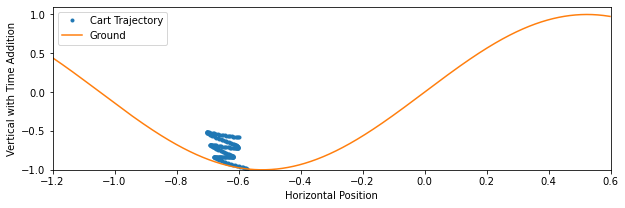

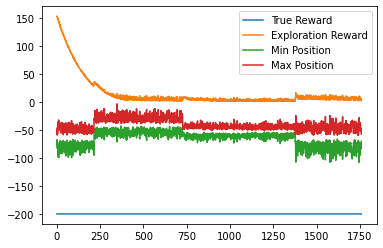

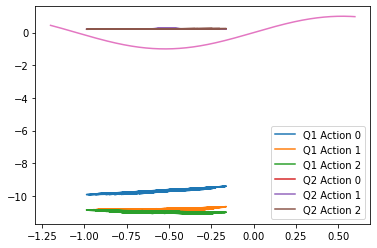

Episode: 1760, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.1025, LossQ2: 0.0016, MinPos: -0.9, MaxPos: -0.5, Alpha: 1.0
Episode: 1761, Reward: -200.0, Expl. Reward:  7.5, LossQ1: 0.4087, LossQ2: 0.0015, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1762, Reward: -200.0, Expl. Reward:  9.5, LossQ1: 0.0649, LossQ2: 0.0023, MinPos: -0.9, MaxPos: -0.3, Alpha: 1.0
Episode: 1763, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.7103, LossQ2: 0.0017, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1764, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.4538, LossQ2: 0.0019, MinPos: -0.8, MaxPos: -0.4, Alpha: 1.0
Episode: 1765, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.3770, LossQ2: 0.0026, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1766, Reward: -200.0, Expl. Reward:  6.9, LossQ1: 0.0555, LossQ2: 0.0021, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1767, Reward: -200.0, Expl. Reward:  7.2, LossQ1: 0.4777, LossQ2: 0.0018, MinPos: -0.9, MaxPos: -0.4, Alpha: 1.0
Episode: 1768, Reward: -

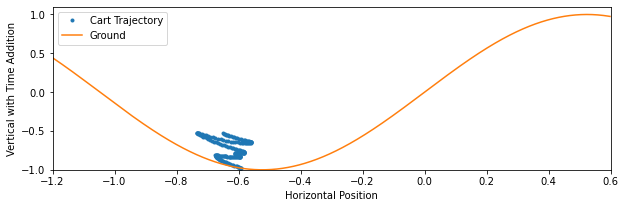

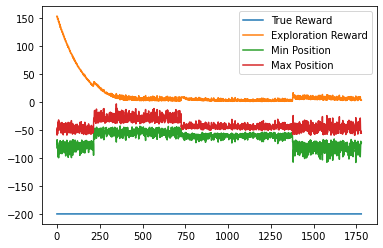

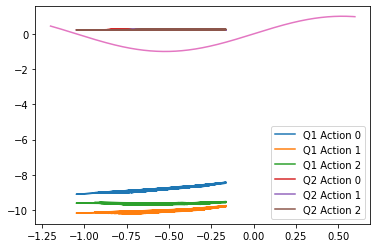

Episode: 1780, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.5419, LossQ2: 0.0025, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1781, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0118, LossQ2: 0.0018, MinPos: -0.8, MaxPos: -0.5, Alpha: 1.0
Episode: 1782, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0537, LossQ2: 0.0015, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1783, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.8520, LossQ2: 0.0024, MinPos: -0.7, MaxPos: -0.5, Alpha: 1.0
Episode: 1784, Reward: -200.0, Expl. Reward: 10.2, LossQ1: 0.5067, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1785, Reward: -200.0, Expl. Reward: 10.5, LossQ1: 0.0012, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1786, Reward: -200.0, Expl. Reward: 10.6, LossQ1: 0.0227, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1787, Reward: -200.0, Expl. Reward: 10.8, LossQ1: 0.1485, LossQ2: 0.0015, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1788, Reward: -

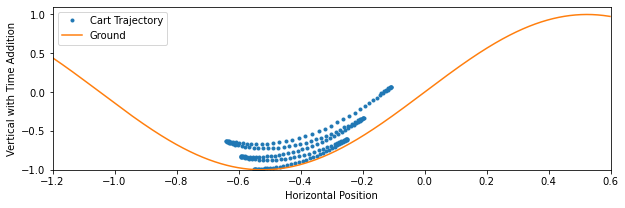

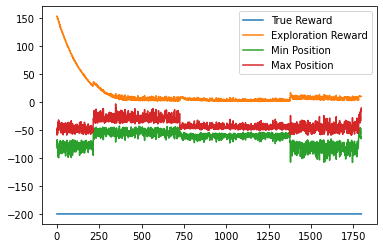

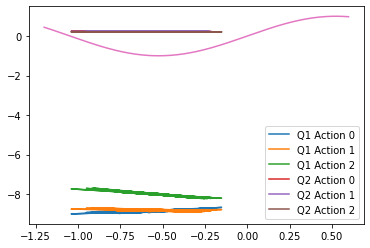

Episode: 1800, Reward: -200.0, Expl. Reward:  8.9, LossQ1: 0.0108, LossQ2: 0.0016, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1801, Reward: -200.0, Expl. Reward:  8.6, LossQ1: 0.7144, LossQ2: 0.0028, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1802, Reward: -200.0, Expl. Reward:  8.6, LossQ1: 0.7586, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1803, Reward: -200.0, Expl. Reward:  8.7, LossQ1: 0.0102, LossQ2: 0.0008, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1804, Reward: -200.0, Expl. Reward:  8.6, LossQ1: 0.6657, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1805, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.6659, LossQ2: 0.0009, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1806, Reward: -200.0, Expl. Reward:  8.1, LossQ1: 0.0225, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1807, Reward: -200.0, Expl. Reward:  7.9, LossQ1: 0.5879, LossQ2: 0.0010, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1808, Reward: -

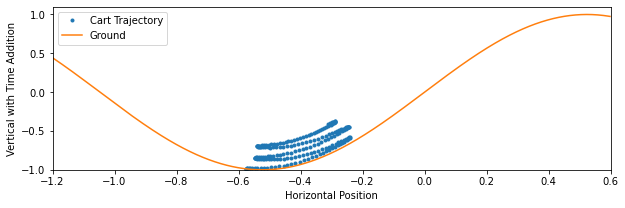

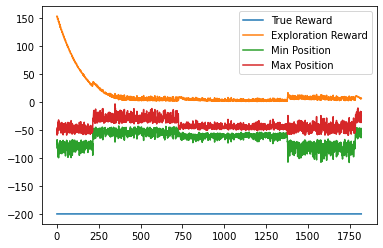

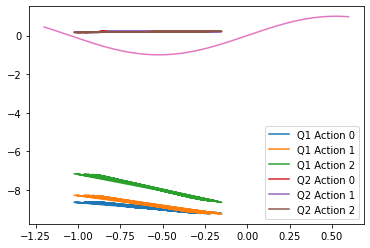

Episode: 1820, Reward: -200.0, Expl. Reward:  5.9, LossQ1: 0.1149, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1821, Reward: -200.0, Expl. Reward:  5.1, LossQ1: 0.0578, LossQ2: 0.0008, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1822, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.2977, LossQ2: 0.0008, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1823, Reward: -200.0, Expl. Reward:  5.4, LossQ1: 0.0798, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1824, Reward: -200.0, Expl. Reward:  5.3, LossQ1: 0.0888, LossQ2: 0.0011, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1825, Reward: -200.0, Expl. Reward:  5.0, LossQ1: 0.0752, LossQ2: 0.0016, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1826, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.6894, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1827, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.4789, LossQ2: 0.0012, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1828, Reward: -

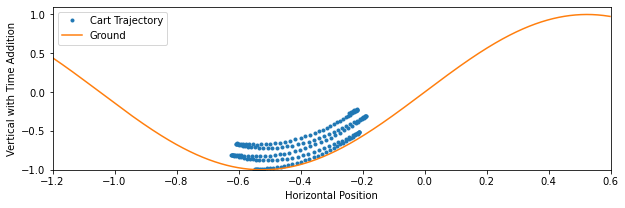

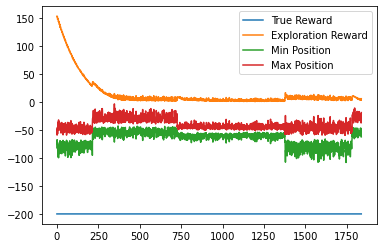

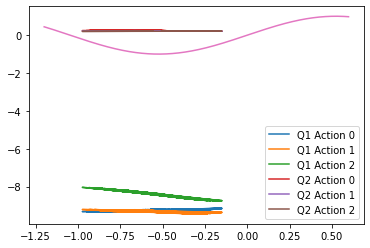

Episode: 1840, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.0150, LossQ2: 0.0019, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1841, Reward: -200.0, Expl. Reward:  4.7, LossQ1: 0.0223, LossQ2: 0.0019, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1842, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.7090, LossQ2: 0.0030, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1843, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.6785, LossQ2: 0.0028, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1844, Reward: -200.0, Expl. Reward:  4.9, LossQ1: 0.6507, LossQ2: 0.0020, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1845, Reward: -200.0, Expl. Reward:  6.2, LossQ1: 0.0320, LossQ2: 0.0024, MinPos: -0.6, MaxPos: -0.1, Alpha: 1.0
Episode: 1846, Reward: -200.0, Expl. Reward:  5.2, LossQ1: 0.0265, LossQ2: 0.0027, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1847, Reward: -200.0, Expl. Reward:  5.6, LossQ1: 0.6027, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1848, Reward: -

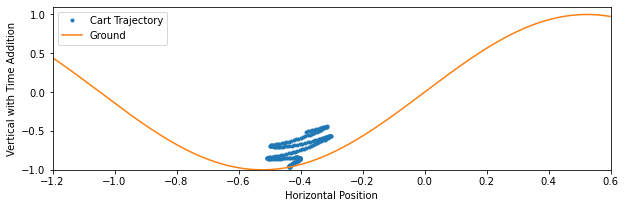

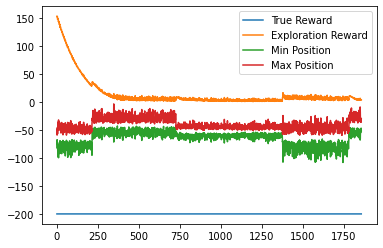

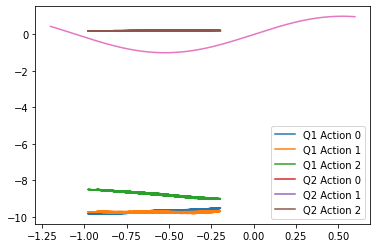

Episode: 1860, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0115, LossQ2: 0.0029, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1861, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.7056, LossQ2: 0.0026, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1862, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.0114, LossQ2: 0.0021, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1863, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0092, LossQ2: 0.0023, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1864, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.5782, LossQ2: 0.0034, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1865, Reward: -200.0, Expl. Reward:  4.2, LossQ1: 0.5375, LossQ2: 0.0033, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1866, Reward: -200.0, Expl. Reward:  4.8, LossQ1: 0.0300, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1867, Reward: -200.0, Expl. Reward:  6.1, LossQ1: 0.0177, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode: 1868, Reward: -

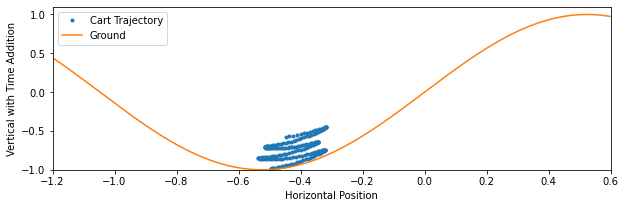

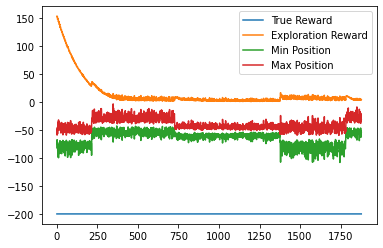

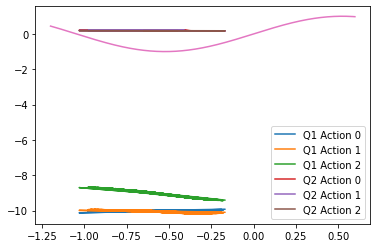

Episode: 1880, Reward: -200.0, Expl. Reward:  4.6, LossQ1: 0.0257, LossQ2: 0.0023, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1881, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.4503, LossQ2: 0.0030, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1882, Reward: -200.0, Expl. Reward:  6.3, LossQ1: 0.0165, LossQ2: 0.0033, MinPos: -0.7, MaxPos: -0.1, Alpha: 1.0
Episode: 1883, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.4829, LossQ2: 0.0020, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1884, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.6153, LossQ2: 0.0021, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1885, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0175, LossQ2: 0.0033, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1886, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.5613, LossQ2: 0.0022, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1887, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.7023, LossQ2: 0.0019, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1888, Reward: -

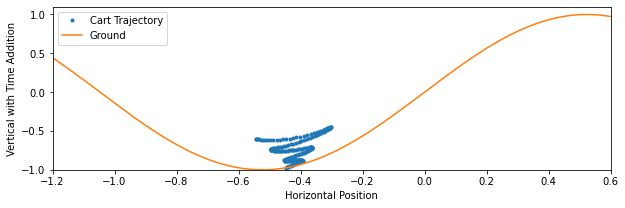

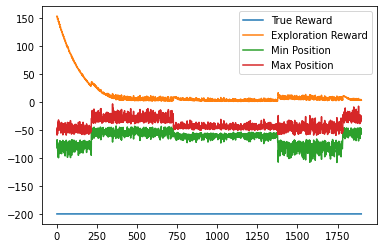

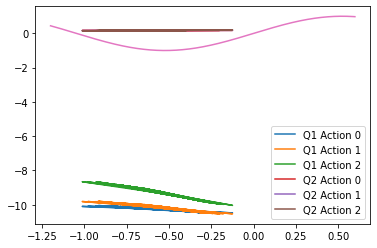

Episode: 1900, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.5850, LossQ2: 0.0015, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1901, Reward: -200.0, Expl. Reward:  3.1, LossQ1: 0.0928, LossQ2: 0.0016, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1902, Reward: -200.0, Expl. Reward:  5.7, LossQ1: 0.0891, LossQ2: 0.0018, MinPos: -0.7, MaxPos: -0.2, Alpha: 1.0
Episode: 1903, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 1.0421, LossQ2: 0.0017, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1904, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.8605, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1905, Reward: -200.0, Expl. Reward:  4.1, LossQ1: 0.0791, LossQ2: 0.0018, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1906, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.4516, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1907, Reward: -200.0, Expl. Reward:  2.8, LossQ1: 0.0300, LossQ2: 0.0024, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1908, Reward: -

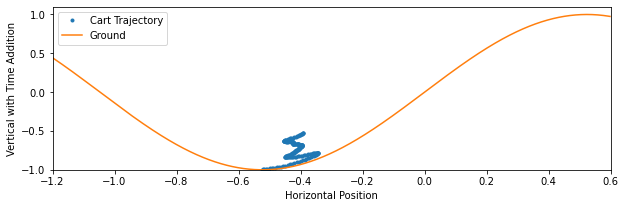

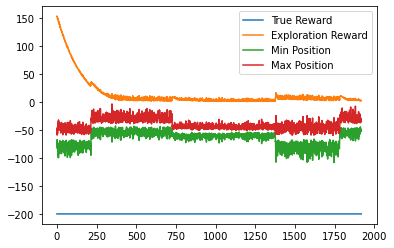

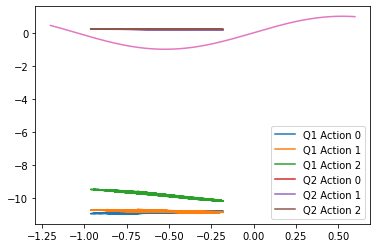

Episode: 1920, Reward: -200.0, Expl. Reward:  3.6, LossQ1: 0.5742, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1921, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.7518, LossQ2: 0.0021, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1922, Reward: -200.0, Expl. Reward:  2.1, LossQ1: 0.9231, LossQ2: 0.0014, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1923, Reward: -200.0, Expl. Reward:  3.3, LossQ1: 0.0354, LossQ2: 0.0021, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1924, Reward: -200.0, Expl. Reward:  3.7, LossQ1: 0.6123, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1925, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.7911, LossQ2: 0.0013, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1926, Reward: -200.0, Expl. Reward:  4.0, LossQ1: 0.0134, LossQ2: 0.0016, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1927, Reward: -200.0, Expl. Reward:  3.5, LossQ1: 0.0136, LossQ2: 0.0009, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1928, Reward: -

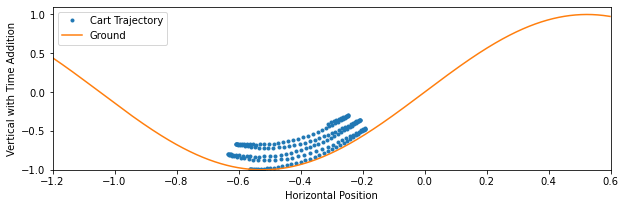

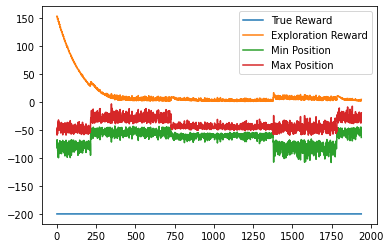

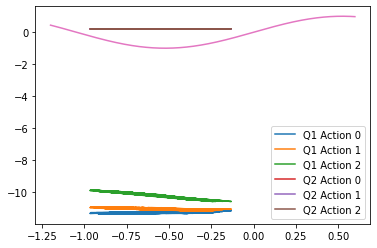

Episode: 1940, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0186, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1941, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0815, LossQ2: 0.0013, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1942, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0418, LossQ2: 0.0014, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1943, Reward: -200.0, Expl. Reward:  2.3, LossQ1: 0.0257, LossQ2: 0.0013, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1944, Reward: -200.0, Expl. Reward:  2.4, LossQ1: 0.0194, LossQ2: 0.0012, MinPos: -0.5, MaxPos: -0.2, Alpha: 1.0
Episode: 1945, Reward: -200.0, Expl. Reward:  2.5, LossQ1: 0.6742, LossQ2: 0.0011, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1946, Reward: -200.0, Expl. Reward:  2.7, LossQ1: 0.5307, LossQ2: 0.0010, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1947, Reward: -200.0, Expl. Reward:  4.5, LossQ1: 0.0275, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1948, Reward: -

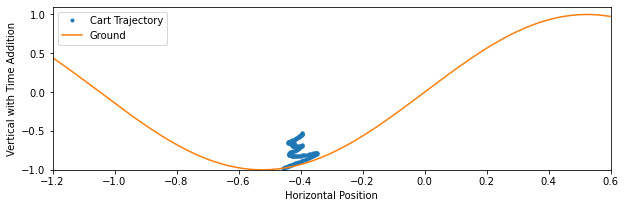

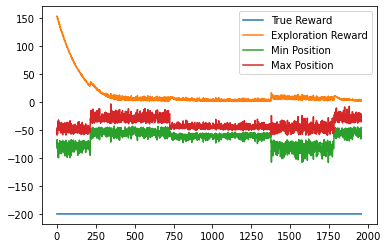

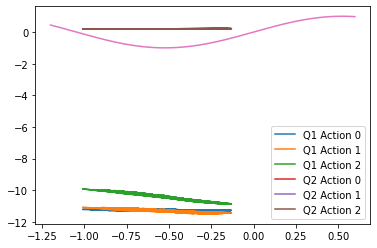

Episode: 1960, Reward: -200.0, Expl. Reward:  2.6, LossQ1: 0.6005, LossQ2: 0.0008, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1961, Reward: -200.0, Expl. Reward:  2.9, LossQ1: 0.7916, LossQ2: 0.0009, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1962, Reward: -200.0, Expl. Reward:  3.0, LossQ1: 0.0501, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0
Episode: 1963, Reward: -200.0, Expl. Reward:  6.4, LossQ1: 0.0330, LossQ2: 0.0012, MinPos: -0.7, MaxPos: -0.0, Alpha: 1.0
Episode: 1964, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.0601, LossQ2: 0.0009, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1965, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0208, LossQ2: 0.0010, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1966, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0168, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1967, Reward: -200.0, Expl. Reward:  4.4, LossQ1: 0.0127, LossQ2: 0.0013, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1968, Reward: -

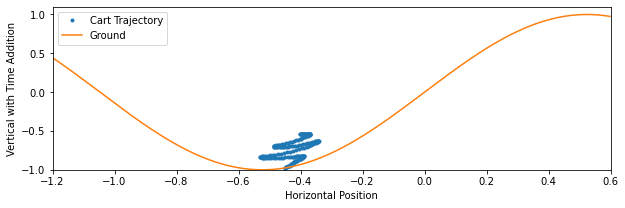

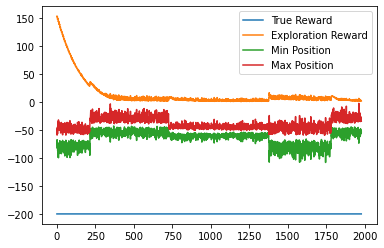

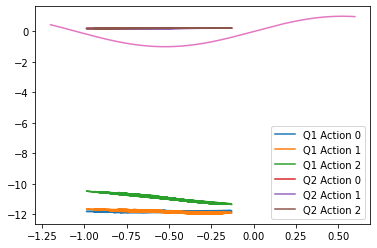

Episode: 1980, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0275, LossQ2: 0.0017, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1981, Reward: -200.0, Expl. Reward:  1.5, LossQ1: 0.0350, LossQ2: 0.0011, MinPos: -0.5, MaxPos: -0.4, Alpha: 1.0
Episode: 1982, Reward: -200.0, Expl. Reward:  1.8, LossQ1: 0.0440, LossQ2: 0.0010, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1983, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0279, LossQ2: 0.0009, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1984, Reward: -200.0, Expl. Reward:  3.8, LossQ1: 0.0414, LossQ2: 0.0014, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1985, Reward: -200.0, Expl. Reward:  3.4, LossQ1: 0.0271, LossQ2: 0.0010, MinPos: -0.6, MaxPos: -0.2, Alpha: 1.0
Episode: 1986, Reward: -200.0, Expl. Reward:  2.0, LossQ1: 0.0239, LossQ2: 0.0008, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1987, Reward: -200.0, Expl. Reward:  2.2, LossQ1: 0.0259, LossQ2: 0.0006, MinPos: -0.5, MaxPos: -0.3, Alpha: 1.0
Episode: 1988, Reward: -

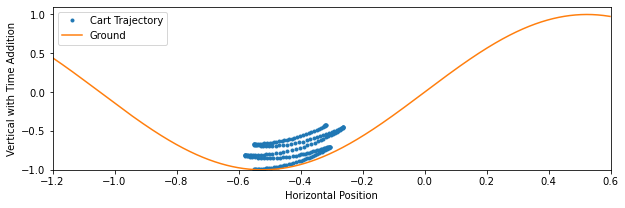

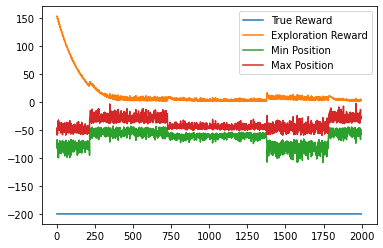

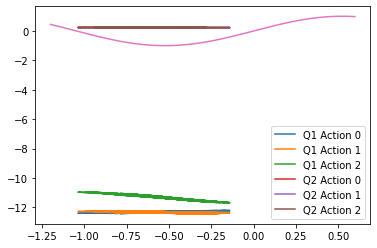

Episode: 2000, Reward: -200.0, Expl. Reward:  3.2, LossQ1: 0.0345, LossQ2: 0.0015, MinPos: -0.6, MaxPos: -0.3, Alpha: 1.0


In [93]:
#Iterate and run
for iter in range(2000): #(params.n_episodes):
    eps += 1
    #alpha = random.uniform(0,1)
    alpha = params.alpha
    d = False
    lst_obs = []
    s = env.reset()
    rsum = 0
    r2sum = 0
    while d==False:
        #Choose Action (vary between exploration and exploitation goals)
        Qs = Qs_mix(state,Q1,Q2,alpha=alpha)
        a = choose_action(Qs,epsilon=0.2,mode='epsgreedy')
        action = a.item()
        
        #Store Transition
        s_, r, d, _ = env.step(action)
        buffer.add(s,a,r,s_,d)
        lst_obs.append(s) #Store states in list for easy visualization
        
        #Track Rewards
        r2 = RND_reward(torch.tensor(s),RND_target,RND)
        rsum += r
        r2sum += r2.item()

        s =  s_
    #Update the Networks
    for update in range(2):
        #Grab samples from buffer
        batch = buffer.sample(batch=params.batchsize)
        sT,aT,rT,s_T,dT = batch
        r2T = RND_reward(sT,RND_target,RND)
        batch_ = sT,aT,r2T,s_T,dT

        Q1, loss_Q1 = updateQ(Q1,params,batch)
        Q2, loss_Q2 = updateQ(Q2,params,batch_)
    if eps % 5 == 4:
        batch = buffer.sample_recent(batch=params.batchsize)
        #batch = buffer.sample(batch=params.batchsize)
        RND, loss = updateRND(RND_target,RND,params,batch)
    #Display status message
    obs_vec = np.array(lst_obs)
    minpos = np.min(obs_vec[:,0])
    maxpos = np.max(obs_vec[:,0])
    reward_list.append([rsum,r2sum,minpos,maxpos])
    print('Episode: %4.0f, Reward: %4.1f, Expl. Reward: %4.1f, LossQ1: %5.4f, LossQ2: %5.4f, MinPos: %3.1f, MaxPos: %3.1f, Alpha: %2.1f' % (eps, 
        rsum, r2sum, loss_Q1, loss_Q2, minpos,maxpos, alpha))
    #Occasionally show visualization of progress
    if eps % 20 == 19:
        plot_trajectory(lst_obs)
        plt.figure()
        rlist,r2list,minpos,maxpos = zip(*reward_list)
        plt.plot(rlist,label='True Reward')
        plt.plot(r2list,label='Exploration Reward')
        plt.plot(100*np.array(minpos),label='Min Position')
        plt.plot(100*np.array(maxpos),label='Max Position')
        plt.plot()
        plt.legend()
        plt.show()
        plt_Qvalue(Q1,Q2,buffer)

#Metrics - performance (total real reward, augmented reward) over time with and without RND
env.close()

/tmp/ipykernel_24865/3170388724.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q1s = Q1(torch.tensor(s))
/tmp/ipykernel_24865/3170388724.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q2s = Q2(torch.tensor(s))


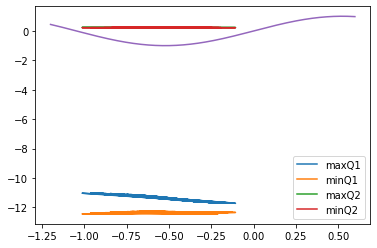

In [94]:
def plt_Qvalue(Q1,Q2,buffer):
    batch = buffer.sample(batch=params.batchsize*20)
    s,_,_,_,_ = batch
    #print('s[:,0]',s[:,0].size())
    with torch.no_grad():
        Q1s = Q1(torch.tensor(s))
        Q2s = Q2(torch.tensor(s))
        Q1max,_ = torch.max(Q1s,dim=1)
        Q1min,_ = torch.min(Q1s,dim=1)
        Q2max,_ = torch.max(Q2s,dim=1)
        Q2min,_ = torch.min(Q2s,dim=1)
    #print('Qmax1',Qmax.size())
    
    plt.figure()
    plt.plot(s[:,0],Q1max,label='maxQ1')
    plt.plot(s[:,0],Q1min,label='minQ1')
    plt.plot(s[:,0],Q2max,label='maxQ2')
    plt.plot(s[:,0],Q2min,label='minQ2')
    plt.legend()
    default = np.array(range(1000))/1000*1.8-1.2
    #plt.plot(obs_vec[:,0],np.sin(3*obs_vec[:,0])+time_addition,'.',
    #    label='Cart Trajectory')
    plt.plot(default,np.sin(3*default),label='Ground')
    plt.show()
plt_Qvalue(Q1,Q2,buffer)

In [95]:
obs_vec = np.array(lst_obs)
minpos = np.min(obs_vec[:,0])
maxpos = np.max(obs_vec[:,0])

print(minpos)
print(maxpos)

-0.57705146
-0.2564937


In [96]:
print('Episode: %4.0f Reward: %4.1f Expl. Reward: %5.2f Alpha: %3.2f' % (eps, rsum, r2sum alpha))

SyntaxError: invalid syntax (3685613191.py, line 1)

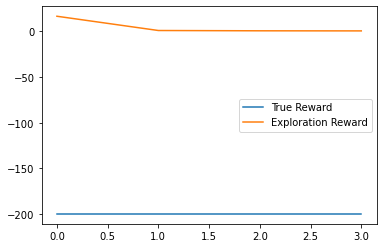

In [ ]:
reward_list
plt.figure()
rlist,r2list = zip(*reward_list)
#plt.plot(reward_list)
plt.plot(rlist,label='True Reward')
plt.plot(r2list,label='Exploration Reward')
plt.legend()
plt.show()

In [ ]:
aa = torch.tensor([[1,0,3]])
print(aa)
print(aa.size())
print(len(aa.size()))
aaa = torch.tensor(s) 
bbb = aaa.size()
print(len(bbb))




tensor([[1, 0, 3]])
torch.Size([1, 3])
2
1


In [ ]:
random.uniform(0,1)

0.7837793655162953

In [ ]:
aa = np.exp(6/12)
bb = np.exp(-6/12)
print(aa,bb)
print(aa/(aa+bb))

1.6487212707001282 0.6065306597126334
0.731058578630005


In [ ]:
env = gym.make('MountainCar-v0')
actionspace = env.action_space
observationspace = env.observation_space
env.close()

printo('actionspace')
printo('observationspace')
printo('env.observation_space.shape')
printo('env.action_space.n')
dims = env.observation_space.shape
dims = (4,) + dims
printo('dims')
a = np.zeros(shape = (dims))
print(a)


testdeque = deque(maxlen=5)
b = np.array([[3,4],[6,7]])
c = np.array([1,2])
testdeque.append(b)
testdeque.append(c)
print(testdeque)

#d = np.random.choice(np.array(range(10)))
d = np.random.choice(range(10))
printo('d')

printo('testdeque(0:1)')

actionspace Discrete(3)
observationspace Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.observation_space.shape (2,)
env.action_space.n 3
dims (4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
deque([array([[3, 4],
       [6, 7]]), array([1, 2])], maxlen=5)
d 9


SyntaxError: invalid syntax (<string>, line 1)